# Analysing cleaned SimilarWeb data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.colors import hsv_to_rgb

import xavy.utils as xu

## Functions

In [2]:
def compute_bin_feat_dist(df, cols, weights='monthly_visits'):
    """
    Compute the weighted fraction of instances that present each value 
    under each column.
    
    Parameters
    ----------
    df : DataFrame
        Table with features as columns and instances as rows. One column
        should be the weights for counting the instances.
    cols : list of str
        Names of columns for which to compute the weigthed fraction of 
        values.
    weights : str
        Name of the column in `df` that contains weights.
    
    Returns
    -------
    feat_dists : dict of Series
        A dict from column names to Series. Each Series contains the 
        weighted fraction of instances that has each value that appears
        in that column.
    """
    
    # Total weights:
    total_weights = df[weights].sum()
    
    # Loop over columns:
    feat_dists = dict()
    for c in cols:
        # Compute weighted fraction of instances in each category available in the specified column:
        feat_dists[c] = df.groupby(c)[weights].sum().sort_values(ascending=False) / total_weights
    
    return feat_dists


def plot_square_pie(top_site_dists, feat_labels, feature, pos, c0='goldenrod', c1='steelblue', cn='0.3', alpha=0.3, factor=1):
    """
    Plot a segmented bar representing fraction of whole for binary 
    categories, allowing for nulls.
    
    Parameters
    ----------
    top_site_dists : dict of series
        Dict produced by function `compute_bin_feat_dist`: each 
        entry is a Series of fractions under each value.
    feat_labels : dict of dict of str
        Labels to be assigned to each value in each entry of 
        `top_site_dists`.
    feature : str
        Name of the key in `top_site_dists` and `feat_labels`.
        This refers to the data and labels to plot.
    pos : int
        Position in the y axis where to place the horinzontal 
        bar.
    c0 : str
        Color of the largest fraction.
    c1: str
        Color of the second fraction.
    cn : str
        Color of the nulls.
    alpha : float
        Transparency for the bars.
    factor : float
        A multiplier for the fraction of visits (e.g. 100 for 
        percentage).
    """
    
    data = top_site_dists[feature].sort_values(ascending=False) * factor

    pl.barh(pos, data.iloc[0], color=c0, alpha=alpha)
    pl.barh(pos, data.iloc[1], left=data.iloc[0], color=c1, alpha=alpha)
    pl.barh(pos, factor - data.sum(), left=data.sum(), color=cn, alpha=alpha)

    pl.text(data.iloc[0] / 2, pos, feat_labels[feature][data.index[0]], ha='center', va='center', color=c0)
    pl.text(data.iloc[0] + data.iloc[1] / 2, pos, feat_labels[feature][data.index[1]], ha='center', va='center', color=c1)


In [3]:
def sel_domains(df, domains):
    """ 
    Return slice of `df` containing the given `domains` (list of str).
    """
    return df.loc[df['domain'].isin(domains)]


def check_redirection_counts(df, domains):
    """
    Last domain should be the sink (the domain to which the 
    others redirect traffic to).
    """
    
    # Select domains:
    aliases_df = sel_domains(df, domains[:-1])
    assert len(aliases_df) == len(domains) - 1
    sink_s = sel_domains(df, [domains[-1]]).iloc[0]
    
    # Visits:
    aliases_visits = aliases_df['monthly_visits'].sum()
    sink_visits = sink_s['monthly_visits']
    
    # Visit avg. duration:
    duration_max  = aliases_df['visit_duration'].max()
    duration_sink = sink_s['visit_duration']
    
    # Bounce rate:
    bounce_min  = aliases_df['bounce_rate'].min()
    bounce_sink = sink_s['bounce_rate']
      
    # Visit avg. duration:
    n_pages_max  = aliases_df['pages_per_visit'].max()
    n_pages_sink = sink_s['pages_per_visit']
    
    print('=== {} ==='.format(domains[-1]))
    
    #display(aliases_df)
    #display(sink_s)
    
    print('VISITS   -- aliases: {}  sink: {}   fraction: {:.2f}'.format(aliases_visits, sink_visits, aliases_visits / sink_visits))
    print('DURATION -- aliases max: {}   sink: {}   {}'.format(duration_max, duration_sink, duration_max < duration_sink))
    print('BOUNCE   -- aliases min: {}   sink: {}   {}'.format(bounce_min, bounce_sink, bounce_min > bounce_sink))
    print('# PAGES  -- aliases max: {}   sink: {}   {}'.format(n_pages_max, n_pages_sink, n_pages_max < n_pages_sink))

In [4]:
def mad(series):
    """
    Compute the median absolute deviation for a `series`.
    Returns a float.
    """
    median = series.median()
    return (series - median).abs().median()

In [5]:
def get_beta(rank):
    """
    Return the exponent of a Powerlaw model fitted to the
    `rank` (array-like).
    """
    pos = np.arange(1, len(rank) + 1)
    model = PowerLaw(flat_x=True, huber=True)
    model.fit(pos, rank)
    return model.exponent_

## Loading data

Load the Similar Web domains' stats:

In [6]:
# Load domain data:
web_df = pd.read_csv('../data/cleaned/similar-web_full-rank_2023-ago-out.csv')
# Add columns:
web_df['total_monthly_time'] = web_df['monthly_visits'] * web_df['visit_duration']

Load the month-over-month change in traffic (a sample of the "all industries" rank):

In [7]:
# Load month-over-month percentual change:
mom_df = pd.read_csv('../data/raw/similar-web_mom-change_all-industries_2023-ago-out.csv')
valid_mom_df = mom_df.query('mom_value != "-" and mom_value != "> 5,000%"')
pc_change = valid_mom_df['mom_value'].str.replace('[,%]', '', regex=True).astype(float) / 100
pc_change.loc[valid_mom_df['mom_sign'].str.contains('negative')] = -pc_change.loc[valid_mom_df['mom_sign'].str.contains('negative')]

Load data about google subdomains:

In [8]:
# Load data about google and its subdomains:
google_df = pd.read_csv('../data/cleaned/similarweb_google-subdomains_2023-out-dez.csv')

Load list of domains with most referring subnets and IPs:

In [9]:
# Load majestic million data:
maj_df = pd.read_csv('../data/raw/majestic_million_2023-10-31.csv')

## Exploration and auxiliary analysis

### Domain names

Domain names are properly stored in its columns:

In [5]:
assert (maj_df['Domain'].str.strip() == maj_df['Domain']).all()
assert (web_df['domain'].fillna('').str.strip() == web_df['domain'].fillna('')).all()

#### IDN domain names?

We see that domains in SimilarWeb are listed in ASCII:

In [6]:
# IDN Domain names:
web_df.loc[web_df['domain'].fillna('').str.contains(r'[^a-zA-Z.0-9\-]')]

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry


In [7]:
# IDN in ASCII:
web_df.loc[web_df['domain'].fillna('').str.contains('--')]

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry
51672,57583,yalla--shoot.live,Sports,Fantasy Sports,NaN,69.0,989669.0,419061.0,338.0,3.17,0.3393,0.140,0.860,NaN,0.0011
52321,58364,xn--8wv97xz6xo7h.online,Sports,Baseball,NaN,38.0,1710000.0,726168.0,151.0,1.91,0.6295,0.064,0.936,NaN,0.0027
54425,60840,xn--80a0aejb8dva.com,Games,Board and Card Games,NaN,53.0,1603000.0,185435.0,283.0,1.58,0.7523,0.842,0.158,NaN,0.0018
63959,72174,xn--90aqok.xn--p1ai,Community and Society,Philanthropy,NaN,68.0,875263.0,641620.0,46.0,1.20,0.8621,0.179,0.821,NaN,0.0018
65350,73834,xn----ftbbbnj3bhgf1ag5ivb.xn--p1ai,Community and Society,Holidays and Seasonal Events,NaN,64.0,645912.0,355029.0,127.0,2.60,0.6057,0.145,0.855,NaN,0.0025
117111,138886,xn--d1acchc3adyj9k.xn--p1ai,Science and Education,Astronomy,NaN,33.0,318302.0,198737.0,123.0,4.27,0.5676,0.233,0.767,NaN,0.0022
125492,150107,xn----8sbcoadje4bwqh5f0e.xn--p1ai,Jobs and Career,Human Resources,NaN,70.0,512258.0,260971.0,820.0,9.23,0.2232,0.083,0.917,NaN,0.0022
154769,191588,xn--80akoaetjlq5g.xn--p1ai,Heavy Industry and Engineering,Metals and Mining,NaN,67.0,284317.0,161567.0,20.0,1.18,0.8717,0.146,0.854,NaN,0.0014
155782,193101,xn--80aegj1b5e.xn--p1ai,Heavy Industry and Engineering,Chemical Industry,NaN,49.0,282719.0,168138.0,117.0,2.38,0.7663,0.468,0.532,NaN,0.0016
318737,471667,xn--90ab0ambbpo.xn--p1ai,Heavy Industry and Engineering,Aerospace and Defense,NaN,26.0,218577.0,143105.0,3.0,1.02,0.9885,0.170,0.830,NaN,0.0047


#### Domain structures

Let's see which domains parts appear in the domain names. Note that names in SimilarWeb are limited to the first 75 websites per industry.

In [191]:
# Select a complete sample of named domains:
domain_complete_limit = web_df.dropna(subset='domain').groupby(['sector', 'industry'])['monthly_visits'].min().max()
domain_complete_df = web_df.loc[web_df['monthly_visits'] >= domain_complete_limit]

In [192]:
# Select SimilarWeb domain names:
web_domain_names = domain_complete_df['domain'].dropna()

In [193]:
# Count domain name splits:
web_dot_counts = web_domain_names.str.count('\.')
max_dots = web_dot_counts.max()
# Homogenize domain splits:
dot_mapper = {n:''.join(['.'] * n) for n in range(max_dots + 1)}
homo_web_domain_names = (max_dots - web_dot_counts).map(dot_mapper) + web_domain_names

In [194]:
# Build DataFrame of domain parts:
web_dparts_df = pd.DataFrame(data=homo_web_domain_names.str.split('.').tolist())

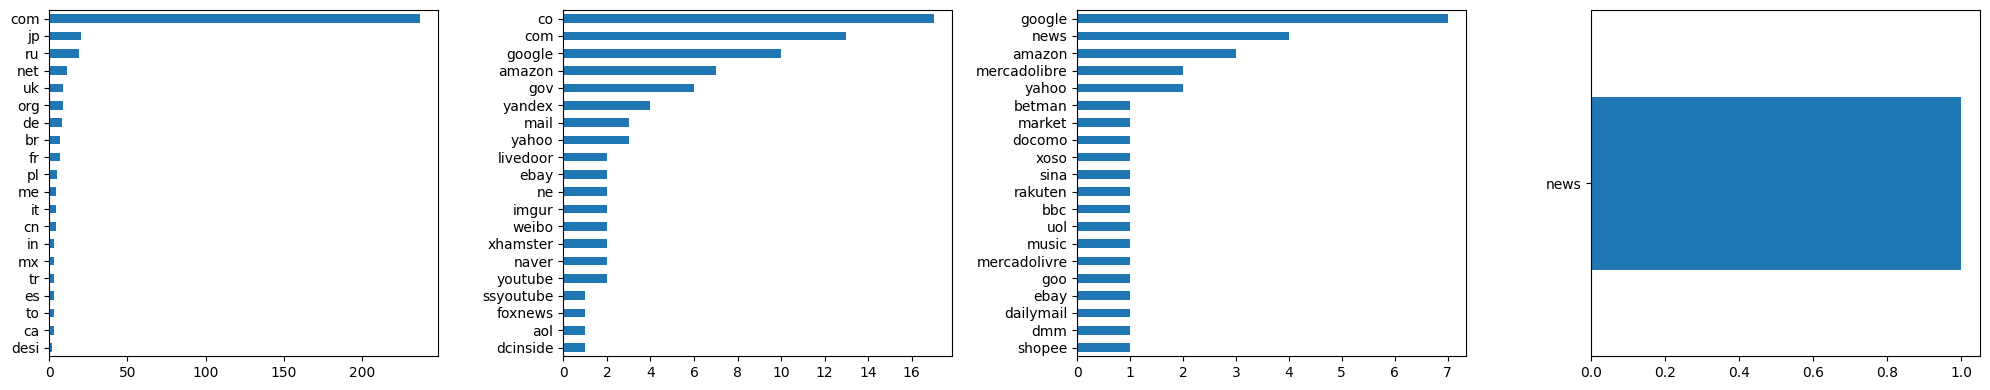

In [195]:
pl.figure(figsize=(20,4))
for p in web_dparts_df.columns[::-1]:
    pl.subplot(1, max_dots + 1, max_dots - p + 1)
    web_dparts_df.replace('', np.NaN)[p].value_counts(ascending=True).tail(20).plot(kind='barh')
pl.tight_layout();

In [188]:
# Group unique domain parts into a single label:
sunburst_df = web_dparts_df.copy()
for c in range(3):
    smap = xu.translate_dict({d:'UNIQUE' for d in web_dparts_df[c].value_counts().loc[web_dparts_df[c].value_counts() == 1].index})
    sunburst_df[c] = sunburst_df[c].map(smap)

In [190]:
# Export to plot on Flourish:
#sunburst_df.to_csv('/home/hxavier/temp/sunburst_domains.csv', index=False)

#### Overlap between datasets

Let's study the overlap between Majestic million and SimilarWeb datasets.

**Conclusions**

* The match by domain is uncommon because:
    * only a small fraction of SimilarWeb data has the domain explicit;
    * some domains in one dataset are split into subdomains in another dataset.

In [9]:
# Set of domains in each dataset:
web_set = set(web_df['domain'].dropna())
maj_set = set(maj_df['Domain'].dropna())
n_web   = len(web_set)

# Select top Majestic domains (same number as in SimilarWeb):
min_df  = maj_df.iloc[:n_web]
min_set = set(min_df['Domain'].dropna())

# Intersections:
inter_set = maj_set & web_set
maj_extra = maj_set - web_set
web_extra = web_set - maj_set
n_inter   = len(inter_set)

# Summary:
print('{} out of {} domains ({:.2f}%) in SimilarWeb are listed in Majestic million.'.format(n_inter, n_web, n_inter / n_web * 100))

10657 out of 13968 domains (76.30%) in SimilarWeb are listed in Majestic million.


In [139]:
# Create joined dataset:
maj_web_df = web_df.join(maj_df.set_index('Domain'), on='domain', how='left')
maj_web_pair_df = maj_web_df.loc[~maj_web_df['RefSubNets'].isnull()]

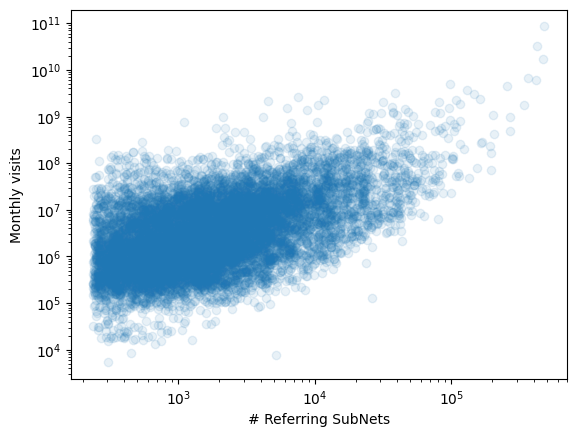

In [196]:
pl.scatter(maj_web_pair_df['RefSubNets'], maj_web_pair_df['monthly_visits'], alpha=0.1)
pl.ylabel('Monthly visits')
pl.xlabel('# Referring SubNets')
pl.yscale('log')
pl.xscale('log')

In [135]:
maj_web_df.loc[maj_web_df['GlobalRank'].isnull() & ~maj_web_df['domain'].isnull(), web_df.columns[:8]].head(20)

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors
86,87,news.yahoo.co.jp,News and Media,News and Media,53.0,8.0,639700000.0,42020000.0
107,108,yiyouliao.com,Computers Electronics and Technology,Programming and Developer Software,79.0,4.0,465000000.0,175700000.0
109,110,music.youtube.com,Computers Electronics and Technology,Search Engines,138.0,17.0,235900000.0,30680000.0
132,133,lazlogistics.ph,Business and Consumer Services,Shipping and Logistics,146.0,2.0,225700000.0,1914000.0
139,140,market.yandex.ru,Ecommerce and Shopping,Marketplace,177.0,21.0,192200000.0,47820000.0
143,144,pemsrv.com,Adult,Adult,98.0,9.0,338500000.0,136800000.0
158,159,tapmad.com,Arts and Entertainment,TV Movies and Streaming,145.0,8.0,225800000.0,98870000.0
163,164,playvideodirect.com,Pets and Animals,Pets and Animals - Other,249.0,1.0,147300000.0,88550000.0
170,171,nettruyenus.com,Games,Games - Other,364.0,2.0,110300000.0,5672000.0
189,190,xnxx.health,Adult,Adult,522.0,37.0,82930000.0,31460000.0


In [136]:
maj_df.query('Domain == "yahoo.co.jp"')

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
471,472,1,yahoo.co.jp,jp,31642,87546,yahoo.co.jp,jp,471,1,31645,87385


What is missing in Majestic million:

In [54]:
# Top domains listed only in SimilarWeb:
web_df.loc[web_df['domain'].isin(web_extra)].dropna(subset='domain').head()

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry
86,87,news.yahoo.co.jp,News and Media,News and Media,53.0,8.0,639700000.0,42020000.0,391.0,3.20,0.2928,0.439,0.561,0.001391,0.0100
107,108,yiyouliao.com,Computers Electronics and Technology,Programming and Developer Software,79.0,4.0,465000000.0,175700000.0,33.0,2.20,0.7597,0.016,0.984,0.001011,0.0305
109,110,music.youtube.com,Computers Electronics and Technology,Search Engines,138.0,17.0,235900000.0,30680000.0,1526.0,10.89,0.2822,0.930,0.070,0.000513,0.0022
132,133,lazlogistics.ph,Business and Consumer Services,Shipping and Logistics,146.0,2.0,225700000.0,1914000.0,2553.0,23.22,0.1959,0.001,0.999,0.000491,0.0778
139,140,market.yandex.ru,Ecommerce and Shopping,Marketplace,177.0,21.0,192200000.0,47820000.0,333.0,8.90,0.2616,0.520,0.480,0.000418,0.0112


What is missing in SimilarWeb:

In [29]:
# Top domains listed only in Majestic million:
only_maj_df = maj_df.loc[maj_df['Domain'].isin(maj_extra)]
only_maj_df.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
9,10,9,googletagmanager.com,com,254802,865332,googletagmanager.com,com,10,9,254648,865060
10,11,2,wordpress.org,org,237571,908754,wordpress.org,org,11,2,237734,909547
11,12,1,youtu.be,be,226660,733785,youtu.be,be,12,1,226431,733989
12,13,3,en.wikipedia.org,org,212121,652304,en.wikipedia.org,org,13,3,211822,651970
13,14,10,play.google.com,com,206206,569269,play.google.com,com,14,10,206132,569524


Possibly a mixed up of subdomains?

In [161]:
web_df.loc[web_df['domain'].fillna('').str.contains('wikipedia')]

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry
7,8,wikipedia.org,Reference Materials,Dictionaries and Encyclopedias,7.0,1.0,4.413000e+09,964600000.0,234.0,3.11,0.596,0.406,0.594,0.009598,0.5642


### Listed categories

Let's verify that the industries in the scraped data is the same as the ones mentioned in SimilarWeb's website, and that none is missing:

In [4]:
# Load list of industries:
industries_df = pd.read_csv('../data/raw/similarweb_industry_categories_2023-12-01.csv')

In [5]:
# Set of listed industries:
listed_industries = set(industries_df['sector'] + ' > ' + industries_df['industry'])

In [6]:
# Set of industries actually captured:
scraped_industries_df = web_df[['sector', 'industry']].drop_duplicates().sort_values(['sector', 'industry'])
scraped_industries = set(scraped_industries_df['sector'] + ' > ' + scraped_industries_df['industry'])

In [7]:
# Industries that were not scraped:
listed_industries - scraped_industries

set()

In [8]:
# Unexpected industries:
scraped_industries - listed_industries

{nan}

**Conclusions:** There are extra domains that were scraped that do not figure in the scraped categories. 
These come from the list for all industries.

### Coverage limit

Similar web shows at most 10k domains for each industry, ordered by monthly visits. If we create a rank of domains per monthly visit, we should not use domains with monthly visits beyond the most stringent motnhly visit cut. We have to find the industry with the highest cut and use this threshold as a limit for our analysis. The monthly visit rank beyond this point is unreliable due to selection effects.

In [10]:
# Smallest monthly visit in each industry:
min_visits_per_industry = web_df.groupby(['sector', 'industry'], dropna=True)['monthly_visits'].min()

In [11]:
# Number of listed domains per industry:
n_entries_per_industry = web_df.groupby(['sector', 'industry'], dropna=False).size()
assert n_entries_per_industry.max() == 10000

# Industries whose domain list was cropped by 10k limit:
cropped_industries = n_entries_per_industry.loc[n_entries_per_industry == 10000].index

In [12]:
# Smallest monthly visits that is present in all industries:
min_visits_complete = min_visits_per_industry.max()
assert min_visits_per_industry.loc[cropped_industries].max() == min_visits_complete

In [13]:
print('Smallest monthly visit for which Similar Web is complete:', min_visits_complete)

Smallest monthly visit for which Similar Web is complete: 140484.0


### Uncertainty in monthly visits

Let's see what is the distribution of month-over-month change in traffic share. 
We will restrict or analysis of the first 8,000 data points to avoid the selection effect in the monthly visits we have seen in the "all industries" rank data.  

In [13]:
# Avoid region of selection effect:
last_pos = 8000
sel_pc_change = pc_change.head(last_pos)

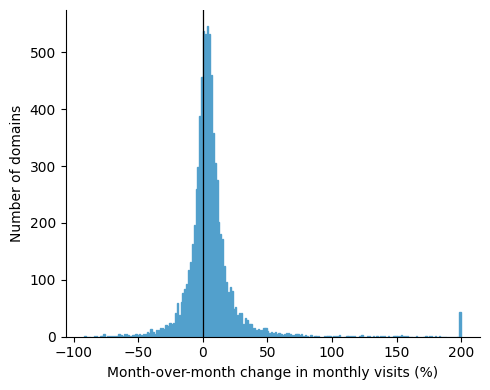

In [294]:
# Histogram of the month-over-month change:
pl.figure(figsize=(5,4))
(sel_pc_change.clip(-1, 2) * 100).hist(bins=200, color=hsv_to_rgb((0.56, 0.6, 0.8)), width=1, edgecolor=hsv_to_rgb((0.56, 0.6, 0.8)))
pl.xlabel('Month-over-month change in monthly visits (%)')
pl.grid(visible=False)
pl.axvline(0, color='0.0', linewidth=0.9)
pl.ylabel('Number of domains')
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/mom-histogram.eps')
pl.show()

We see that the distribution is assymetrical and can reach more than 100%. This means that the numbers are fractional changes, not additive percentual points. Assuming the total traffic does not change from one month to the other (which is wrong, given the distribution has a mean above 0), this fractional change is applicable to monthly visits as well.

In [15]:
# Stats:
sel_pc_chance_median  = sel_pc_change.median()
sel_pc_chance_dev     = sel_pc_change.std()
sel_pc_chance_mad     = np.median(np.abs(sel_pc_change - sel_pc_chance_median))
sel_pc_change_absdiff = np.abs(sel_pc_change).mean()

In [16]:
# Average absolute difference (scatter): 
sel_pc_change_absdiff

0.15033807500000002

In [17]:
# Median of the distribution (bias):
sel_pc_chance_median

0.0359

In [18]:
# One sigma range:
np.percentile(pc_change, [16, 84])

array([-0.0511,  0.1885])

#### Dispersion per monthly visits

Let's see if there is a dependency of the distribution with respect to the position in the rank:

In [245]:
# Compute rolling statistics for MoM changes:
win_size = 200 # Number of instances in the window:
step = 40 # How many instances to skip before setting the new window:
pos = np.arange(1, 1 + len(sel_pc_change))
avg_pos       = pd.Series(pos).rolling(win_size, center=True, step=step).mean().dropna()
#mean_change   = sel_pc_change.rolling(win_size, center=True, step=step).mean().dropna()
median_change = sel_pc_change.rolling(win_size, center=True, step=step).median().dropna()
mad_change    = sel_pc_change.rolling(win_size, center=True, step=step).agg(mad).dropna()
#abs_change    = sel_pc_change.rolling(win_size, center=True, step=step).agg(lambda x: np.mean(np.abs(x - x.median()))).dropna()

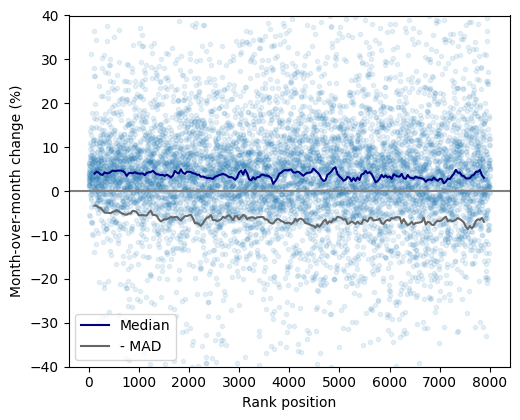

In [247]:
# Plot MoM change vs. rank position and the bins' statistics:
pl.figure(figsize=(5.3,4.3))
pl.scatter(pos, sel_pc_change * 100, marker='.', alpha=0.1)
#pl.plot(avg_pos, mean_change * 100, label='Mean', color='firebrick')
#pl.plot(x, -y * 100, label='Mean', color='firebrick')
pl.plot(avg_pos, median_change * 100, label='Median', color='navy')
#pl.plot(avg_pos, -dev_change * 100, label='StDev', color='y')
pl.plot(avg_pos, -mad_change * 100, label='- MAD', color='0.4')
#pl.plot(avg_pos, -abs_change * 100, label='Abs. dev.', color='g', linestyle='--')
pl.axhline(0, color='0.5')
pl.ylim([-40, 40])
pl.legend()
pl.xlabel('Rank position')
pl.ylabel('Month-over-month change (%)')
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/mom-vs-position.png', dpi=600)
#pl.grid(axis='y')
pl.show()

The median is reasonably stable through the rank, while the MAD is significantly smaller for the very top domains: they vary less than the others.

In [26]:
# Bootstrap the measurement of the MAD:
n_samples = 4000 # Number of resamples
ssize = 1000     # Window size (in n. of instances)  
offset  = 7000   # Offset (in n. of instances) between samples
# Top ranking domains:
top_mad = np.array([mad(sel_pc_change.iloc[:ssize].sample(ssize, replace=True)) for _ in range(n_samples)])
top_med = np.array([np.median(sel_pc_change.iloc[:ssize].sample(ssize, replace=True)) for _ in range(n_samples)])
# Low ranking domains:
bottom_mad = np.array([mad(sel_pc_change.iloc[offset:offset + ssize].sample(ssize, replace=True)) for _ in range(n_samples)])
bottom_med = np.array([np.median(sel_pc_change.iloc[offset:offset + ssize].sample(ssize, replace=True)) for _ in range(n_samples)])

Below we compute the p-value for the positive difference in the median. Beware that we probably must take into account the multiple comparisons problem, so statistical significance is further reduced.

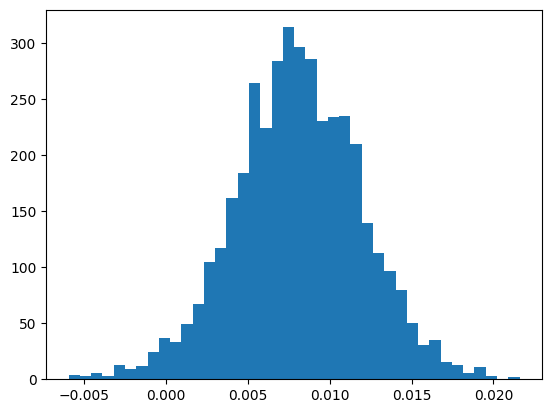

p-value: 0.0225


In [31]:
# Median difference distribution:
pl.hist(top_med - bottom_med, bins=40)
pl.show()
# Median difference p-value:
print('p-value:', (top_med - bottom_med < 0).mean())

Now we compare the bootstrapped MAD distributions for the top and the bottom of the rank:

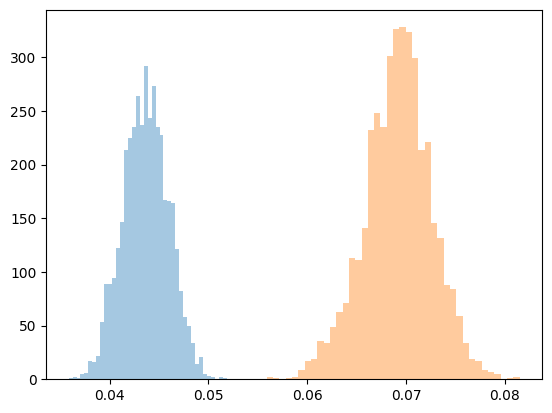

In [25]:
# Compare MAD bootstrapped distributions: 
pl.hist(top_mad, bins=40, alpha=0.4)
pl.hist(bottom_mad, bins=40, alpha=0.4)
pl.show()

**Conclusion:** We see above that the central measure and disperson are almost constant with respect to rank position, except for the very last ones (removed by our selection). This means that:

1. We can assume the statistical fluctuation is the same, no matter the rank (except at the very end).
2. The end of the SimilarWeb rank is composed mainly by fast growing domains. Maybe this is a selection effect (SimilarWeb is only interested in small domains if they are growing fast).
3. However, the slight smaller dispersion for the top domains is statistically significant, so they vary less month to month that the other websites.

Let's see the distribution of MoM change without the last to bins (small websites):

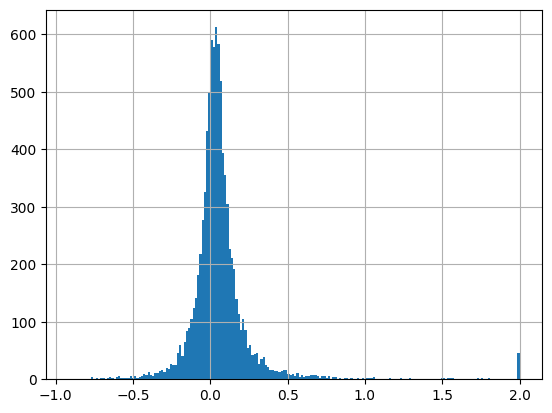

In [12]:
# MoM change distribution without the rank tail:
no_tail_change = pc_change.values.reshape((22,-1))[:-2].reshape((-1,))
pl.hist(no_tail_change.clip(-1, 2), bins=200)
pl.grid()
pl.show()

#### Significance of the mean

The mean MoM change is above 0. Let's see if this is statistically significant:

In [13]:
# Bootstrap:
n_samples = 10000
pc_size = len(pc_change)
pc_mean = np.array([pc_change.sample(pc_size, replace=True).mean() for n in range(n_samples)])
pc_median = np.array([pc_change.sample(pc_size, replace=True).median() for n in range(n_samples)])

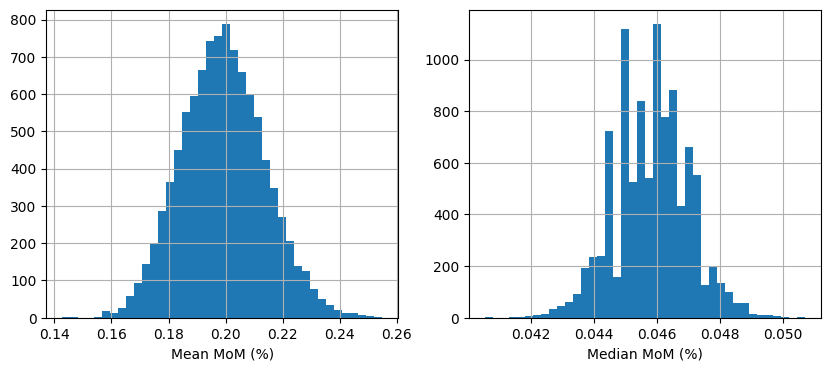

In [14]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pd.Series(pc_mean).hist(bins=40)
pl.xlabel('Mean MoM (%)');

pl.subplot(1,2,2)
pd.Series(pc_median).hist(bins=40)
pl.xlabel('Median MoM (%)');

**Conclusions:** The average MoM is significantly larger than zero. That is: 
1. either these top websites are concentrating traffic over time 
(getting traffic from smaller websites that do not figure in the data); 
2. or the overall absolute traffic is increasing over time;
3. or this is an overall traffic fluctuation on the web (e.g. seasonal).

#### Additive log error

Although the log of the MoM change has less kurtosis, it is still not Gaussian:

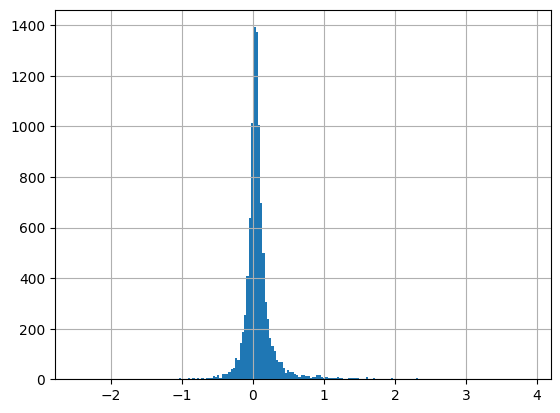

In [15]:
log_pc = np.log(1 + pc_change)
log_pc.hist(bins=200);

In [16]:
log_pc.mean()

0.08378302305166867

In [17]:
log_pc.std() / np.sqrt(len(log_pc))

0.0031600797687816543

### Monthly visits trends

Let's analyze the rank of most visited domains. We will limit the analysis to the mininum number of visits that are accounted for in all industries.

In [14]:
from xavy.mltools import PowerLaw

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [15]:
# Select only domains with monthly visits above the value present in all industries.
visit_complete_df = web_df.loc[web_df['monthly_visits'] >= min_visits_complete]
n_domains_complete = len(visit_complete_df)
pos = np.arange(1, 1 + n_domains_complete)
visits = visit_complete_df['monthly_visits'].sort_values(ascending=False).values

In [16]:
# Fit powerlaw to the whole data:
powerlaw = PowerLaw(flat_x=True, huber=True)
powerlaw.fit(pos, visits)
visits_model = powerlaw.predict(pos)

In [251]:
'{:e}'.format(powerlaw.scale_)

'4.091162e+11'

In [252]:
powerlaw.exponent_

-1.190331619034808

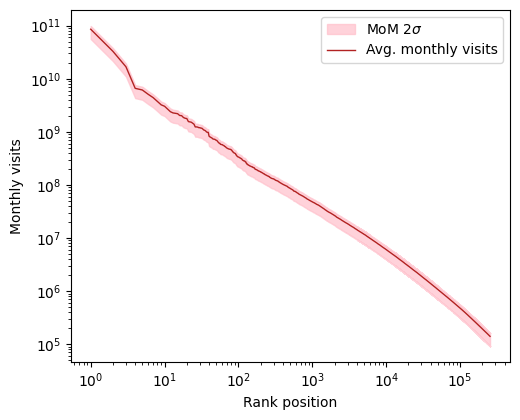

In [265]:
# Plot model 1-sigma-equivalent interval:
pl.figure(figsize=(5.3,4.3))
pc_dev = 1 + np.percentile(sel_pc_change - sel_pc_change.median(), [2, 88])
#pl.fill_between(pos, visits_model * pc_dev[0], visits_model * pc_dev[1], color='0.8')
#pl.plot(pos, visits_model, label='Power law', color='k', alpha=0.5, linestyle='--', linewidth=1);
# Plot data:
sys_err = 0.42
pl.fill_between(pos, visits * pc_dev[0], visits * pc_dev[1], color='pink', alpha=0.7, label='MoM $2\sigma$')
#pl.fill_between(pos, visits * pc_dev[0], visits * pc_dev[1], color=hsv_to_rgb((0.0, 0.2, 0.95)), label='MoM $2\sigma$')
pl.plot(pos, visits, color='firebrick', linewidth=1, label='Avg. monthly visits');
# Format:
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Rank position')
pl.ylabel('Monthly visits')
pl.legend()
pl.tight_layout()
pl.savefig('../resultados/10_artigo/images/traffic-distribution-vs-position.png', dpi=600)
pl.show()

Curiosity: let's see how the domains are distributed as a function of monthly visits. This works as an empirical estimate of the probability distribution of domains as a function of monthly visits.

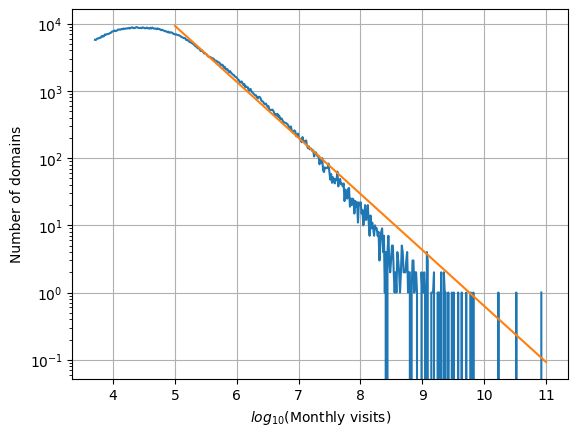

In [254]:
# Count the domains per log(visits) bins:
counts, edges = np.histogram(np.log10(web_df['monthly_visits'].dropna()), bins=500)
bins = (edges[1:] + edges[:-1]) / 2
# Plot:
pl.plot(bins, counts)
pl.yscale('log')
pl.xlabel('$log_{10}$(Monthly visits)')
pl.ylabel('Number of domains')
pl.grid()
# Add powerlaw model:
x = np.arange(5, 12)
x0 = 7              # Pivot point.
y0 = np.log10(200)  # Pivot point.
b = 1 / 1.2         # Powerlaw exponent.
a = y0 + b * x0
y = 10.0 ** (a - b * x)
pl.plot(x, y)
pl.show()

#### k top domains after visit variation

In [21]:
def regen_rank(y, pc_change):
    """
    Apply random fractional changes to `y`, sampled from 
    `pc_change`, and sort the result by descending 
    order.
    
    Parameters
    ----------
    y : array
        Central values that will be perturbed by factors 
        of `1 + p`, where `p` is sampled from `pc_change`.
    pc_change : Series
        Pandas Series with fractional differences between 
        the current value and a new one (from a different
        month).
    """
    n = len(y)
    regen_y = y + np.log(1 + pc_change.sample(n, replace=True).values)
    return pd.Series(regen_y).sort_values(ascending=False).values

The plot below shows what happens when we select a fixed set of domains that were the top ranking in monthly visits and follow then over the next month.
We see that this creates a sudden drop in the monthly visits at the end of the rank. This happens because the positions lost by negative variations at the end of the rank 
are not compensated by positive variations from domains below the last position in the rank. This might explain why we see such sudden drop in SimilarWeb data:
the ranking might take into account data from previous months.

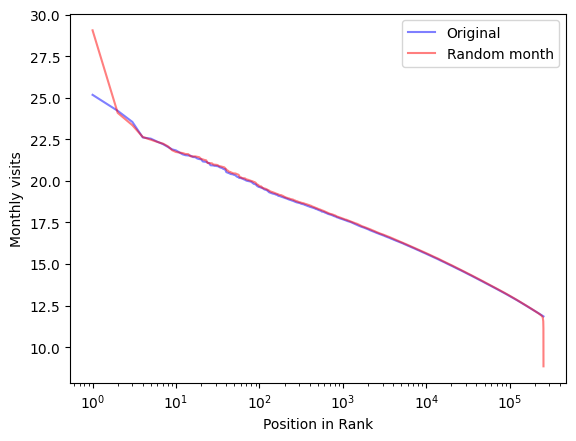

In [32]:
pos = np.arange(1, 1 + len(visit_complete_df))
pl.plot(pos, np.log(visits), label='Original', alpha=0.5, color='b')
pl.plot(pos, regen_rank(np.log(visits), sel_pc_change - sel_pc_change.median()), label='Random month', alpha=0.5, color='r');
pl.xscale('log')
pl.xlabel('Position in Rank')
pl.ylabel('Monthly visits')
#pl.xlim([100000, 300000])
#pl.ylim([8, 14])
pl.legend()
pl.show()

### Traffic share

In [266]:
import xavy.dataframes as xd

In [267]:
def Tint(N, V0, beta):
    """
    Compute the total monthly visits for `N` domains given
    a power law model and the integral approximation.
    """
    Taprox = V0 / (beta + 1) * ((N + 1) ** (beta + 1) - 1) + V0 / 2
    return Taprox


def estimate_missing_visits(n_included, n_total, V0, beta):
    """
    Compute an estimate of the total monthly visits among the
    domains not included in the SimilarWeb data, given a 
    power-law model and the integral approximation.
    
    Parameters
    ----------
    n_included : int
        Number of domains included in SimilarWeb data, for 
        which the monthly visits is given. They are assumed to
        be the most visited websites in the Web, i.e. the data
        is assumed to be complete up to this position in the
        rank of most visited domains.
    n_total : int
        Total number of domains on the Web.
    V0 : float
        Scale of the power-law model.
    beta : float
        Exponent of the power-law model.
    
    Returns
    -------
    visits_extra : float
        Estimate of the total monthly visits of the domains
        beyond the first `n_included` in the rank.
    """
    
    visits_included = Tint(n_included, V0, beta)
    visits_total    = Tint(n_total, V0, beta)
    visits_extra    = visits_total - visits_included
    
    return visits_extra

[Verisign](https://blog.verisign.com/domain-names/verisign-q1-2023-the-domain-name-industry-brief/) says there are 354 million registered domains in march 2023. 

In [268]:
# Number of registered domains:
n_registered_domains = 354e6
# Estimate monthly visits for the whole Web: 
pow_model_total_visits = Tint(n_registered_domains, powerlaw.scale_, powerlaw.exponent_)
pow_model_complete_visits = Tint(n_domains_complete, powerlaw.scale_, powerlaw.exponent_)
visits_norm = visit_complete_df['monthly_visits'].sum() + pow_model_total_visits - pow_model_complete_visits

In [269]:
# Compute exponent for cummulative slices of the data:
step_powerlaw = PowerLaw(flat_x=True, huber=True)
last_domain = np.logspace(1, np.log10(n_domains_complete), 100).astype(int)
betas = np.array([step_powerlaw.fit(pos[:l], visits[:l]).exponent_ for l in last_domain])

# Estimate total monthly visits for smallest exponent:
beta_min = betas.min()
V0_min   = visits[-1] / pos[-1] ** beta_min
min_total_visits    = Tint(n_registered_domains, V0_min, beta_min)
min_complete_visits = Tint(n_domains_complete, V0_min, beta_min)
min_norm = visit_complete_df['monthly_visits'].sum() + min_total_visits - min_complete_visits

# Estimate total monthly visits for largest exponent:
beta_max = betas.max()
V0_max   = visits[-1] / pos[-1] ** beta_max
max_total_visits    = Tint(n_registered_domains, V0_max, beta_max)
max_complete_visits = Tint(n_domains_complete, V0_max, beta_max)
max_norm = visit_complete_df['monthly_visits'].sum() + max_total_visits - max_complete_visits

In [270]:
# Estimate total monthly visits for largest exponent:
beta_best = powerlaw.exponent_
V0_best   = visits[-1] / pos[-1] ** beta_best
best_total_visits    = Tint(n_registered_domains, V0_best, beta_best)
best_complete_visits = Tint(n_domains_complete, V0_best, beta_best)
best_norm = visit_complete_df['monthly_visits'].sum() + best_total_visits - best_complete_visits

In [271]:
# Fraction of the visits that are associated to an undisclosed domain:
web_df.dropna(subset=['domain'])['monthly_visits'].sum() / visits_norm

0.514466512549816

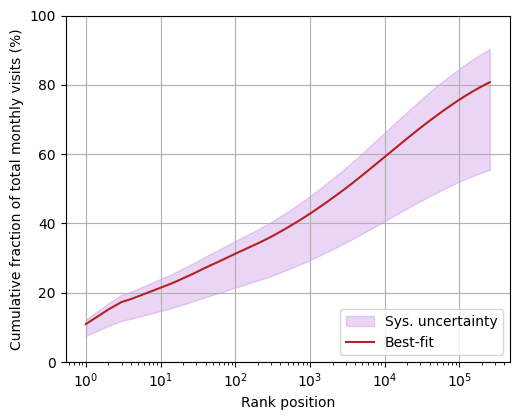

In [275]:
cum_abs_visits = visit_complete_df['monthly_visits'].sort_values(ascending=False).cumsum().values
cum_visits = cum_abs_visits / visits_norm
best_cum_visits = cum_abs_visits / best_norm
min_cum_visits = cum_abs_visits / min_norm
max_cum_visits = cum_abs_visits / max_norm

# Plot:
pl.figure(figsize=(5.3,4.3))
pl.fill_between(pos, max_cum_visits * 100, min_cum_visits * 100, color='darkorchid', alpha=0.2, label='Sys. uncertainty')
pl.plot(pos, cum_visits * 100, color='firebrick', label='Best-fit')
#pl.plot(pos, best_cum_visits * 100, color='0.2', linestyle='--', linewidth=1, label='Best 2')
# Format:
#pl.axhline(50, color='0.4', linewidth=1)
pl.xscale('log')
pl.xlabel('Rank position')
pl.ylabel('Cumulative fraction of total monthly visits (%)')
pl.grid()
pl.ylim([0,100])
pl.legend(loc='lower right')
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/cum-traffic-share.png', dpi=600)
pl.show()

The plot above shows that, under the assumptions that SimilarWeb really monitors the most visited websites, 
the list containing complete top websites from all industries covers the majority of visits even in a conservative scenario,
where the ranking powerlaw is less steep. This validates our strategy on using SimilarWeb data as a coarse overall picture of 
Web experience of world users.

In [273]:
# Number of domains that contain 50% of the monthly visits:
half_visits_best = np.argmin(np.abs(cum_visits - 0.5)) + 1
half_visits_min  = np.argmin(np.abs(min_cum_visits - 0.5)) + 1
half_visits_max  = np.argmin(np.abs(max_cum_visits - 0.5)) + 1

### Gini coefficient

In [30]:
def extrap_visits(p0, p1, V0, beta):
    """
    Generator of a sequence of powerlaw outputs, from
    `p0 + 1` to `p1` (inclusive).
    """
    p = p0 + 1
    while p <= p1:
        yield V0 * p ** beta
        p += 1

def extrap_weighted_visits(p0, p1, V0, beta, N_domains):
    """
    Generator of a sequence of powerlaw outputs multiplied 
    by the reversed rank position, from the unreversed
    positions (from the largest to the smallest output) 
    `p0 + 1` to `p1` (inclusive).
    """    
    p = p0 + 1
    while p <= p1:
        yield (N_domains + 1 - p) * V0 * p ** beta
        p += 1

def huge_sum(generator, p_ini, p_fim, p_step, gen_pars):
    """
    Sum all numbers from `generator(*gen_pars)`, from positions
    `p_ini + 1` to `p_fim` (inclusive). The total sum is divided
    into partial sums with at most `p_step` elements.
    """
    
    # Standardize input:
    i0 = int(p_ini)
    i1 = int(p_fim)
    di = int(p_step)
    
    partial_sums = []
    for p in range(i0, i1 + 1, di):
        # Limits partial sum to total sum limit: 
        p_max = min(i1, p + di)
        # Partial sum:
        obj = generator(p, p_max, *gen_pars)
        r = sum(obj)
        partial_sums.append(r)

    return sum(partial_sums)

def calc_extrap_gini(measured_visits, V0, beta, N_final, partial_sum_len=100000000):
    """
    Compute the Gini index for domain visits distribution using 
    the measured visits and the powerlaw extrapolation for the 
    unobserved visits.

    Parameters
    ----------
    measured_visits : array, 1D
        Number of monthly visits of the observed domains, ordered
        from the most visited to the least visited.
    V0 : float
        Scale of the powerlaw to be used in the extrapolation.
    beta : float
        Exponent to be used in the powerlaw extrapolation.
    N_final : int
        Total number of domains, including the observed and 
        unobserved ones.
    partial_sum_len : int
        Maximum number of elements to be used in each internal 
        partial sum when computing Gini index terms from 
        extrapolated visits.

    Returns
    -------
    gini : float
        The Gini inequality index, from 0 (perfect equality) to 
        1 (perfect inequality).
    """
    
    # Create rank ṕosition array:
    pos = np.arange(1, len(measured_visits) + 1, dtype=np.int64)

    # Compute gini terms for observed data:
    top_sum_A = ((N_final + 1 - pos) * measured_visits).sum()
    top_sum_B = measured_visits.sum()

    # Compute gini terms for extrapolated data:
    extrap_sum_A = huge_sum(extrap_weighted_visits, pos[-1], N_final, partial_sum_len, (V0, beta, N_final))
    extrap_sum_B = huge_sum(extrap_visits, pos[-1], N_final, partial_sum_len, (V0, beta))

    # Compute Gini:
    gini = 2 / N_final * (top_sum_A + extrap_sum_A) / (top_sum_B + extrap_sum_B) - 1
    
    return gini

In [41]:
gini_best = calc_extrap_gini(visits, powerlaw.scale_, powerlaw.exponent_, n_registered_domains)

In [42]:
gini_max = calc_extrap_gini(visits, V0_max, beta_max, n_registered_domains)

In [43]:
gini_min = calc_extrap_gini(visits, V0_min, beta_min, n_registered_domains)

### Summary table

In [50]:
total_visits_arr = np.array([min_norm, visits_norm, max_norm])
visits_last = [V0_min * n_registered_domains ** beta_min, powerlaw.scale_ * n_registered_domains ** beta_best, V0_max * n_registered_domains ** beta_max]
summary_df = pd.DataFrame({'beta':[beta_min, beta_best, beta_max], 'total_visits': total_visits_arr, 'user_daily_visits': total_visits_arr / 5.35e9 / 30,
              'visits_last':visits_last, 'half_visits_at':[half_visits_min, half_visits_best, half_visits_max], 'gini':[gini_min, gini_best, gini_max]})

In [52]:
summary_df.sort_values('beta', ascending=False)

,beta,total_visits,user_daily_visits,visits_last,half_visits_at,gini
2,-0.831921,1.136295e+12,7.079721,341.086412,62621,0.818038
1,-1.190332,7.811434e+11,4.866937,27.270792,2938,0.969475
0,-1.515763,6.984705e+11,4.351841,2.418366,1342,0.994995


## Most visited websites

In [17]:
import xavy.explore as xe
import xavy.dataframes as xd

In [18]:
# Ensure websites are ordered by monthly visits:
top_rank_df = visit_complete_df.sort_values('monthly_visits', ascending=False) 

### Most visited industries

In [19]:
import xavy.mltools as ml

In [20]:
# Load industry names:
industries_df = pd.read_csv('../data/raw/similarweb_industry_categories_2023-12-01.csv')

In [21]:
# Check which industry names are shared by different sectors:
xd.check_guarda_compartilhada(top_rank_df, 'industry', 'sector')

industry
Public Records and Directories    [Reference Materials, Science and Education]
Name: sector, dtype: object

We wil ignore the separation between the two "Public Records and Directories" industries since their sectors are similar enough.
Moreover, as shown below, their combined position in the rank does not justify more attention spent on them. 

In [27]:
# Count the monthly visits per industry:
visits_per_industry = top_rank_df.groupby('industry')['monthly_visits'].sum().sort_values(ascending=False)
industry_pos = np.arange(1, 1 + len(visits_per_industry))

In [28]:
# Position of "Public records" in the industry rank (by monthly visits): 
np.arange(len(visits_per_industry))[visits_per_industry.index == 'Public Records and Directories']

array([87])

Let us fit the industry rank (in terms of monthly visits $V$) using the model: 
$$V = A e^{-\alpha p} + B e^{-\beta p} $$
where $p$ is the position of the industry in the rank:

In [29]:
# Instantiate models:
exp_1 = ml.Exponential(flat_x=True, huber=True)
exp_2 = ml.Exponential(flat_x=True, huber=True)

# Define validity range:
exp_switch_pos = 6
exp_end_pos = 175

# Fit first exponential:
exp_1.fit(industry_pos[:exp_switch_pos], visits_per_industry.values[:exp_switch_pos])
exp_fit_1 = exp_1.predict(industry_pos)
# Fit second exponential:
exp_2.fit(industry_pos[exp_switch_pos:exp_end_pos], visits_per_industry.values[exp_switch_pos:exp_end_pos])
exp_fit_2 = exp_2.predict(industry_pos)

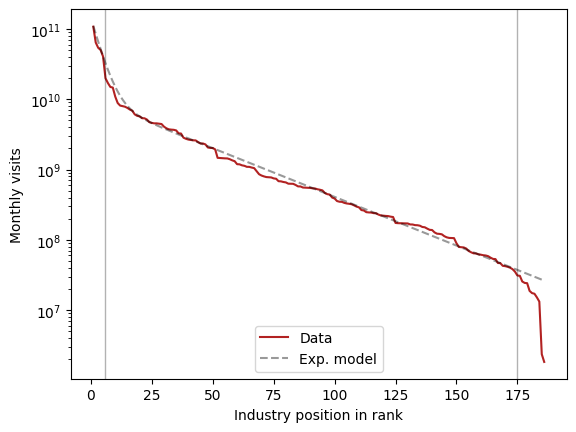

In [30]:
# Plot data:
pl.plot(industry_pos, visits_per_industry.values, color='firebrick', label='Data')

# Plot model:
pl.plot(industry_pos, exp_fit_1 + exp_fit_2, color='k', linestyle='--', alpha=0.4, label='Exp. model')

# Ranges used for fitting:
pl.axvline(exp_switch_pos, color='k', alpha=0.3, linewidth=1)
pl.axvline(exp_end_pos, color='k', alpha=0.3, linewidth=1)

# Format:
pl.yscale('log')
pl.ylabel('Monthly visits')
pl.xlabel('Industry position in rank')
pl.legend()
pl.show()

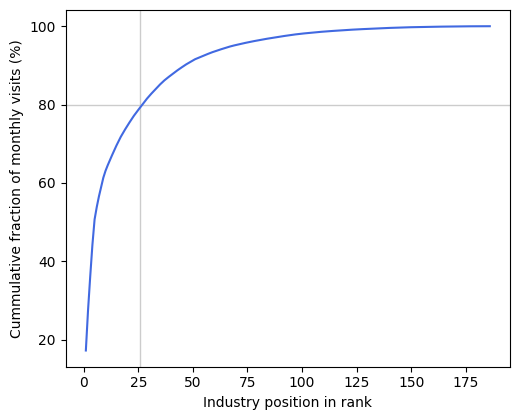

In [279]:
# Plot cummulative share of monthly visits
cum_visits_per_industry = visits_per_industry.cumsum()
pl.figure(figsize=(5.3,4.3))

ind_rank_limit = 26
pl.axvline(ind_rank_limit, color='0.8', linewidth=1)
pl.axhline(80, color='0.8', linewidth=1)

pl.plot(industry_pos,  cum_visits_per_industry / cum_visits_per_industry.iloc[-1] * 100, color='royalblue')

pl.ylabel('Cummulative fraction of monthly visits (%)')
pl.xlabel('Industry position in rank')
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/cum-industry-traffic-share.eps')
pl.show()

In [32]:
# Monthly visits share of top industries:
cum_visits_per_industry.iloc[ind_rank_limit] / cum_visits_per_industry.iloc[-1]

0.8009524017893153

In [302]:
## Industry:
shortener = {'Social Networks and Online Communities': 'Social Networks', 
             'Computers Electronics and Technology - Other': r'Computers & Tech - Other',
             'Programming and Developer Software': r'Prog. & Dev. Software',
             'Video Games Consoles and Accessories': 'Video Games',
             'Graphics Multimedia and Web Design': r'Multimedia & Web Design',
             'Ecommerce and Shopping - Other': 'Ecommerce - Other'}
toplot_industries = visits_per_industry.rename(shortener)
toplot_industries.index = toplot_industries.index.str.replace(' and ', r' & ')

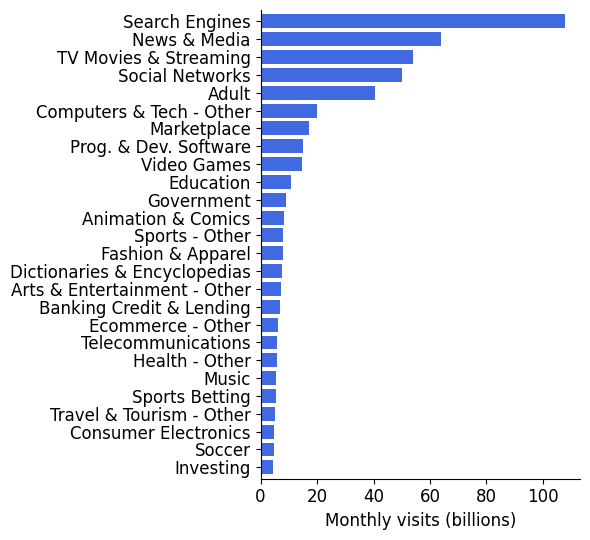

In [307]:
pl.figure(figsize=(6, 5.5))

(toplot_industries.iloc[ind_rank_limit - 1::-1] / 1e9).plot(kind='barh', width=0.78, color='royalblue')
pl.xlabel('Monthly visits (billions)', fontsize=12)
pl.tick_params(labelsize=12)
pl.ylabel(None)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/top-industries-monthly-visits.eps', bbox_inches='tight')
pl.show()

In [34]:
# Monthly visits share of the top 5 industries:
cum_visits_per_industry.iloc[4] / cum_visits_per_industry.iloc[-1]

0.5069120443812968

#### Visits distribution in an industry

Now let's see the traffic share inside a specific industry:

In [140]:
def plot_industry_share(web_df, industry, normalize=False, max_domains=20, title=True):
    
    # Standardize input:
    if type(industry) == str:
        industry = [industry]
    
    sel_df = web_df.loc[web_df['industry'].isin(industry)].sort_values('monthly_visits')
    
    to_plot = sel_df.set_index('domain')['monthly_visits']

    if normalize is True:
        to_plot = to_plot / to_plot.sum()
    
    to_plot.tail(max_domains).plot(kind='barh', width=0.78, color='rosybrown')
    if title == True:
        pl.title(' / '.join(industry))

    return to_plot

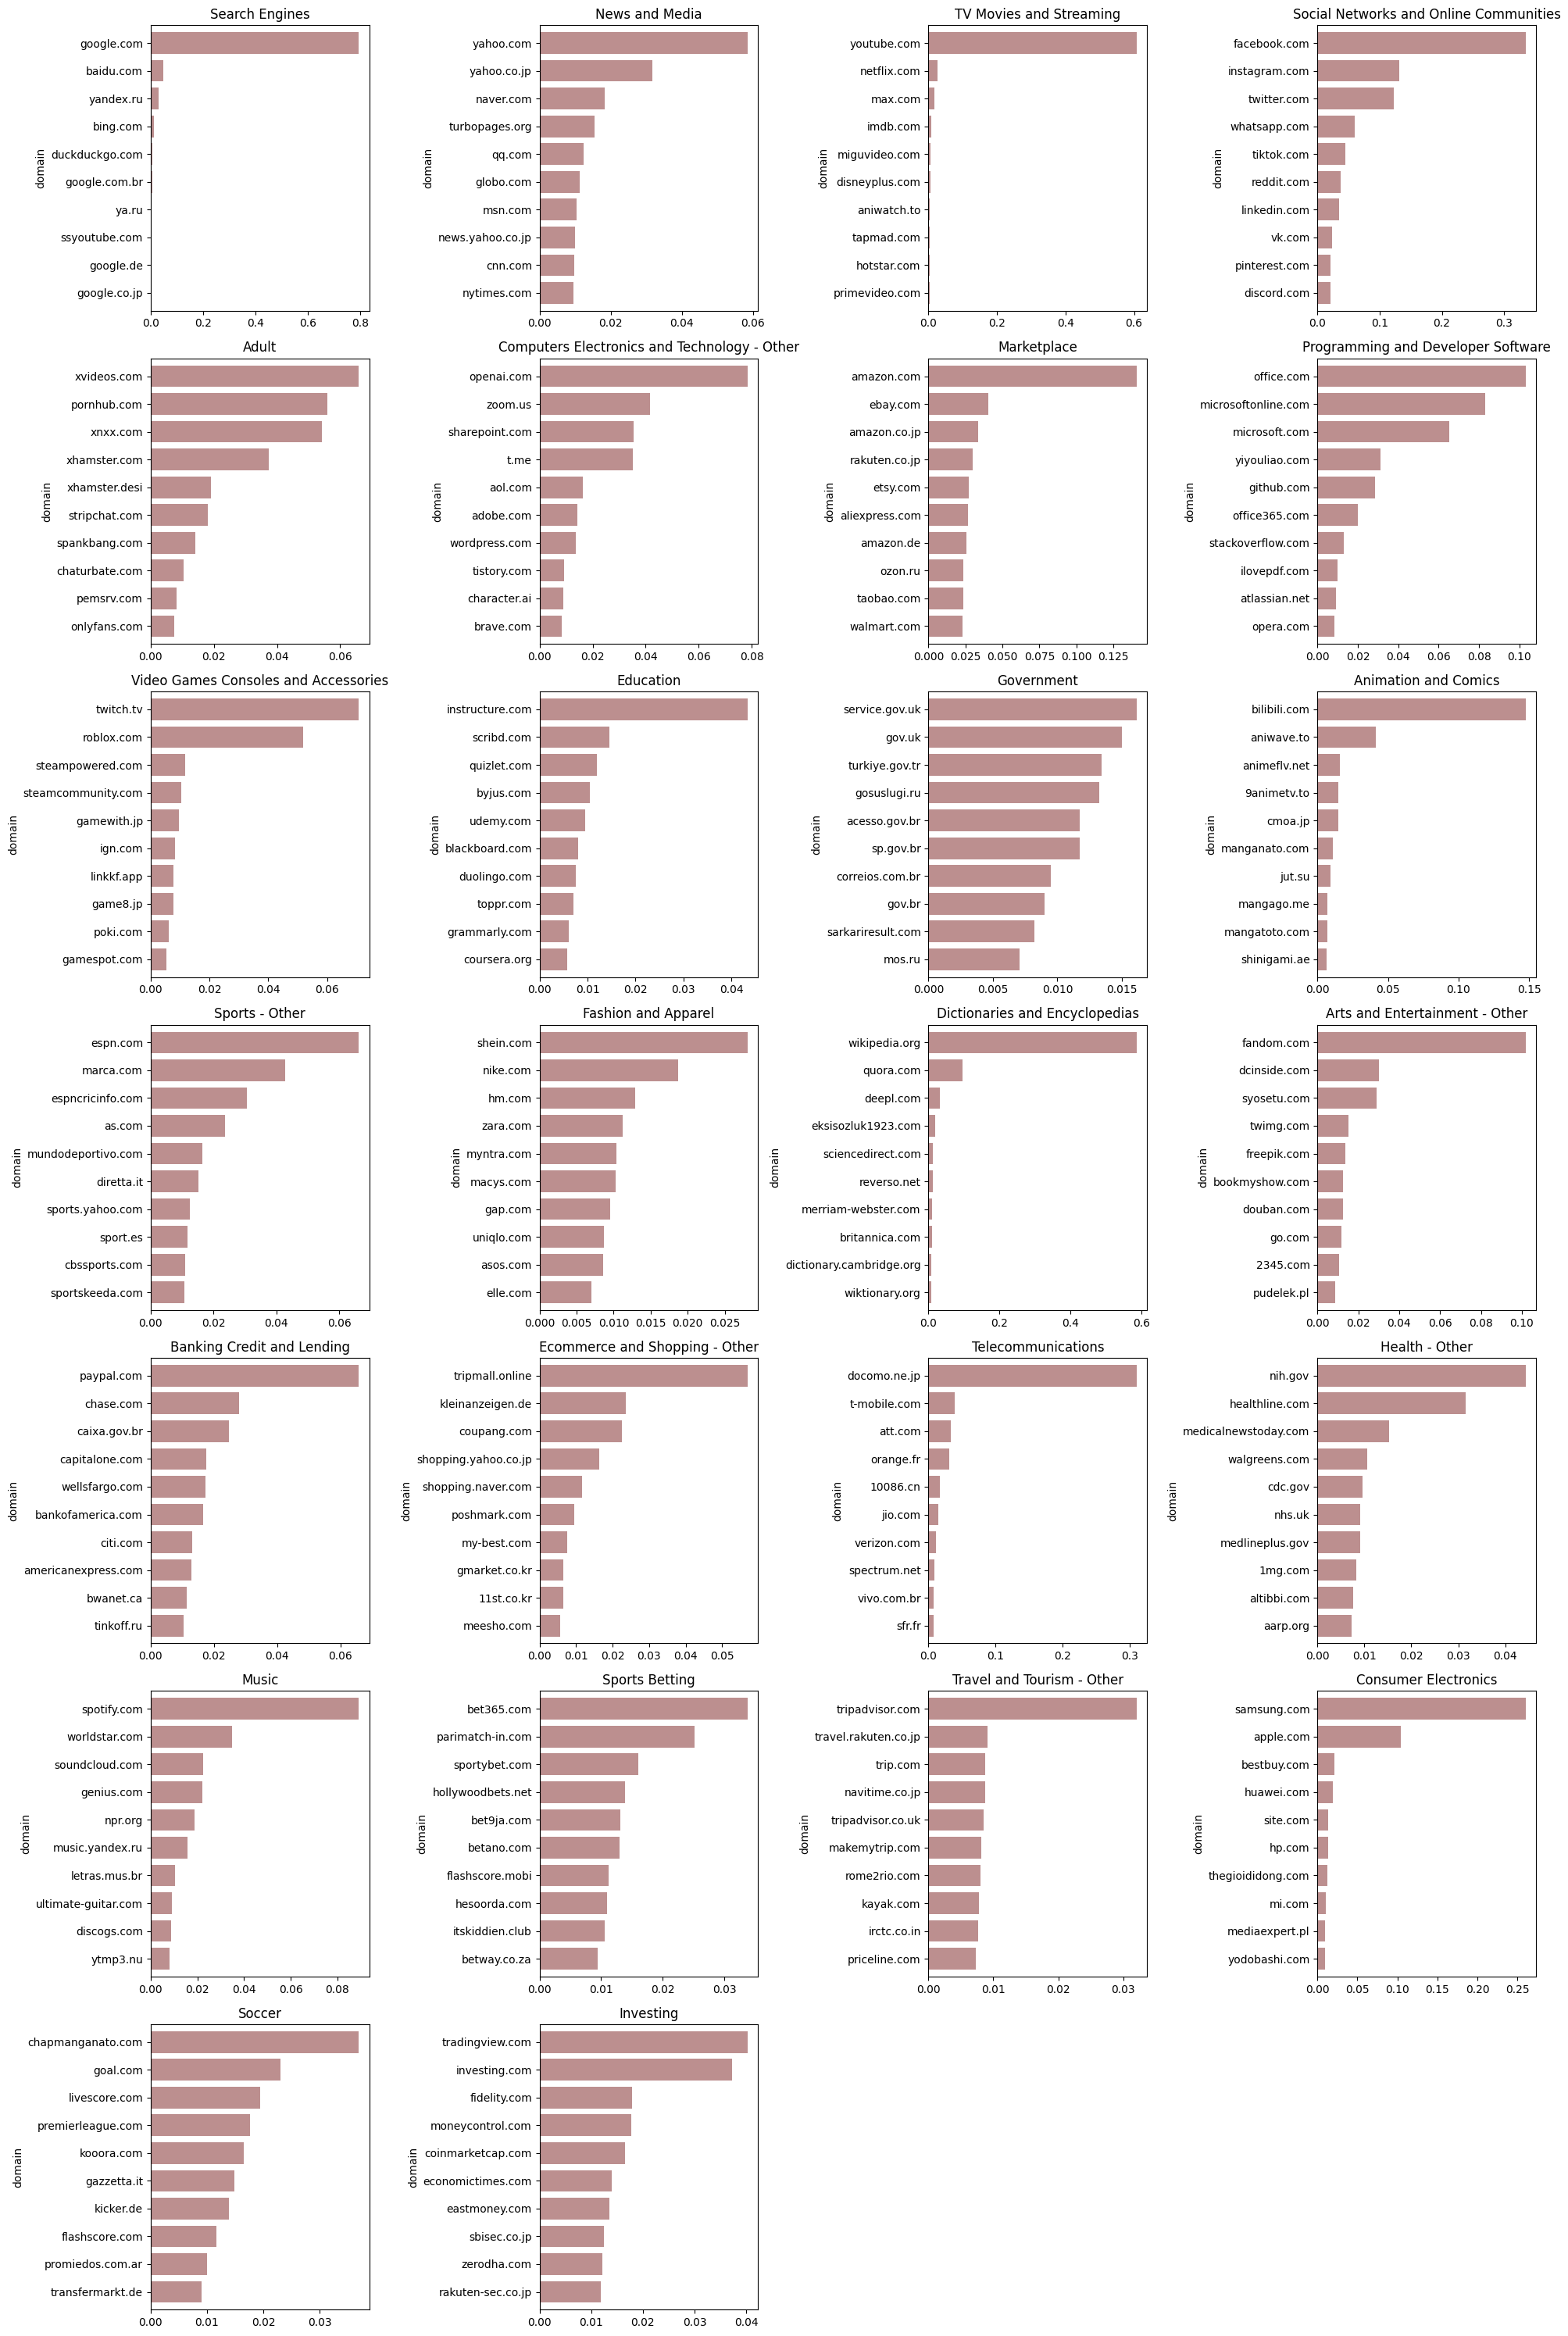

In [148]:
#plot_industry_share(visit_complete_df, visits_per_industry.index[31])
pl.figure(figsize=(20,30))
for i, s in enumerate(visits_per_industry.index[:26]):
    pl.subplot(7, 4, 1 + i)
    plot_industry_share(visit_complete_df, s, normalize=True, max_domains=10)
pl.tight_layout()
pl.show()

Let's get the exact numbers. Also, we will use the data from the complete industry:

In [103]:
def industry_traffic_share(web_df, ind, max_out=5):
    
    # Select available data:
    w_df   = web_df.loc[~web_df['monthly_visits'].isnull()]
    w_df   = w_df.loc[w_df['monthly_visits'] > 0]
    
    # Select industry:
    sel_df = w_df.loc[w_df['industry'].isin([ind])].sort_values('monthly_visits', ascending=False)
    print('# domains in "{}":'.format(ind), len(sel_df))
    
    # Return share in industry:
    mv_ind = sel_df.set_index('domain')['monthly_visits']
    return mv_ind.iloc[:max_out] / mv_ind.sum()

In [104]:
industry_traffic_share(web_df, visits_per_industry.index[0])

# domains in "Search Engines": 9986


domain
google.com        0.793028
baidu.com         0.047130
yandex.ru         0.029832
bing.com          0.011452
duckduckgo.com    0.007457
Name: monthly_visits, dtype: float64

In [106]:
industry_traffic_share(web_df, visits_per_industry.index[2])

# domains in "TV Movies and Streaming": 10000


domain
youtube.com      0.605146
netflix.com      0.026799
max.com          0.018068
imdb.com         0.008991
miguvideo.com    0.006738
Name: monthly_visits, dtype: float64

In [121]:
networks_share = industry_traffic_share(web_df, visits_per_industry.index[3])
networks_share

# domains in "Social Networks and Online Communities": 10000


domain
facebook.com     0.332323
instagram.com    0.130517
twitter.com      0.121443
whatsapp.com     0.059960
tiktok.com       0.044185
Name: monthly_visits, dtype: float64

In [122]:
networks_share['facebook.com'] + networks_share['instagram.com'] + networks_share['whatsapp.com']

0.5228005651363123

In [118]:
industry_traffic_share(web_df, visits_per_industry.index[14])

# domains in "Dictionaries and Encyclopedias": 9881


domain
wikipedia.org         0.564197
quora.com             0.093240
deepl.com             0.030748
eksisozluk1923.com    0.018704
sciencedirect.com     0.012118
Name: monthly_visits, dtype: float64

### Largest time spenditure

Let's check the rank of domains by total time spent on it (i.e. summing the time spent by all visitors):

In [65]:
# Ensure websites are ordered by total monthly time:
top_time_df = visit_complete_df.sort_values('total_monthly_time', ascending=False) 

Let's compute the total time spent in each industry:

In [66]:
# Count the total monthly time per industry:
time_per_industry = top_time_df.groupby('industry')['total_monthly_time'].sum().sort_values(ascending=False)
industry_time_pos = np.arange(1, 1 + len(time_per_industry))

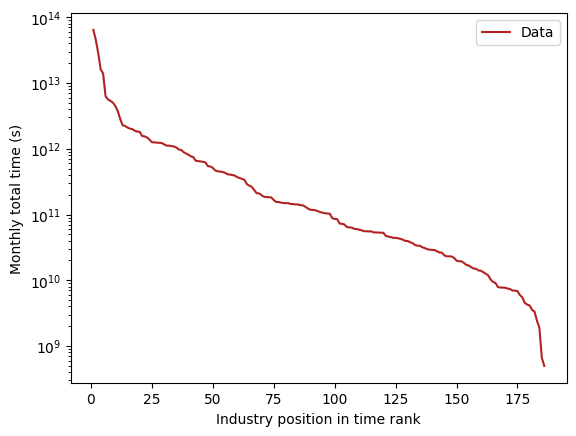

In [67]:
# Plot data:
pl.plot(industry_time_pos, time_per_industry.values, color='firebrick', label='Data')

# Format:
pl.yscale('log')
pl.ylabel('Monthly total time (s)')
pl.xlabel('Industry position in time rank')
pl.legend()
pl.show()

We see above that the time-spent rank has a similar distribution than the monthly-visits rank.

Below we see the total time spent in each one of the top industries. The rank changes a bit, but it is quite similar to the monthly visits one.

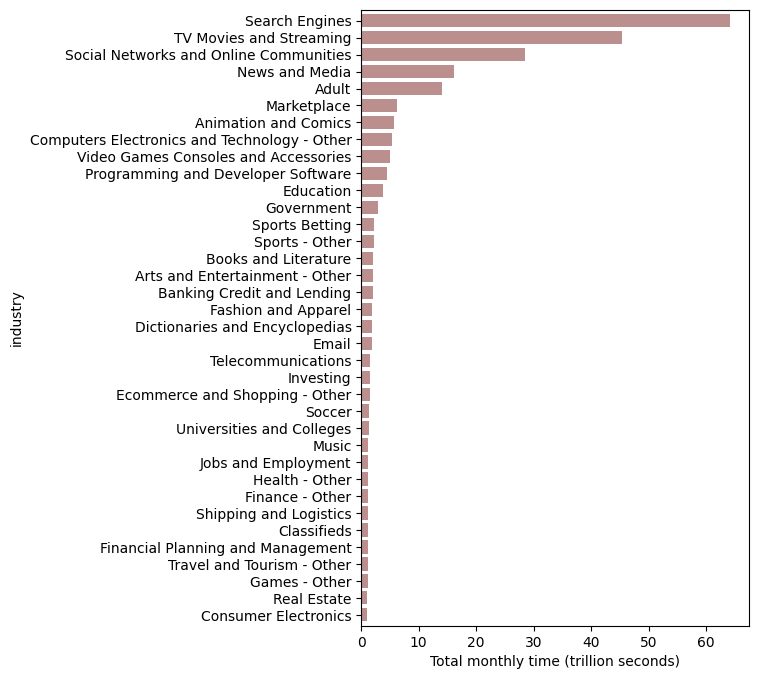

In [68]:
pl.figure(figsize=(5,8))
(time_per_industry.iloc[35::-1] / 1e12).plot(kind='barh', width=0.78, color='rosybrown')
pl.xlabel('Total monthly time (trillion seconds)')
pl.show()

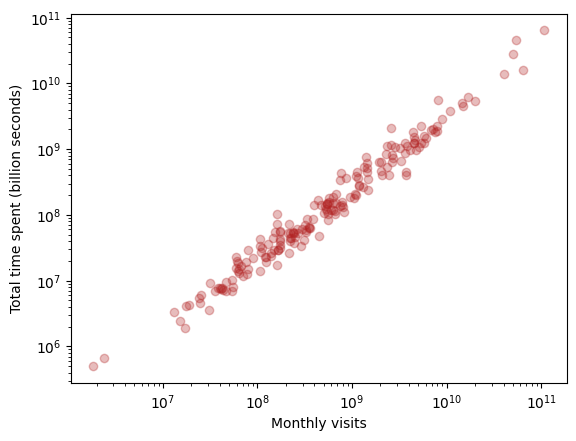

In [69]:
# Correlation between monthly visits and total time spent per industry:
# Build DataFrame:
time_visit_df = pd.DataFrame()
time_visit_df['time']   = time_per_industry / 1000
time_visit_df['visits'] = visits_per_industry
# Plot:
pl.scatter(time_visit_df['visits'], time_visit_df['time'], alpha=0.3, color='firebrick')
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Monthly visits')
pl.ylabel('Total time spent (billion seconds)')

pl.show()

Let's see the average visit duration per industry:

In [74]:
# Computing average time per industry and its fractional difference to the mean:
ind_avg_visit_duration  = visit_complete_df.groupby('industry')['total_monthly_time'].sum() / visit_complete_df.groupby('industry')['monthly_visits'].sum()
tot_avg_visit_dutation  = visit_complete_df['total_monthly_time'].sum() / visit_complete_df['monthly_visits'].sum()
ind_frac_visit_duration = ind_avg_visit_duration.sort_values() / tot_avg_visit_dutation - 1

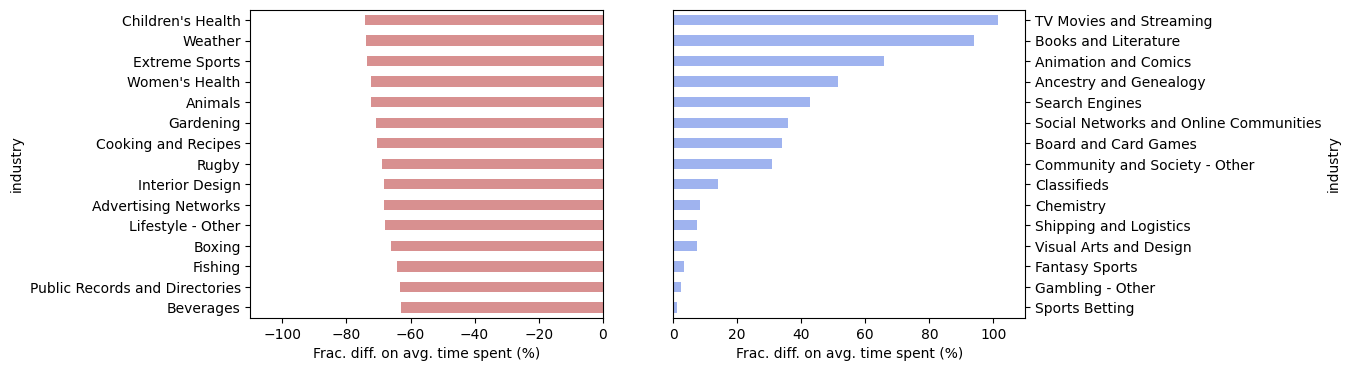

In [101]:
# Plot the fractional difference:

pl.figure(figsize=(10,4))
ax = pl.subplot(1,2,1)
(ind_frac_visit_duration.iloc[15:0:-1] * 100).plot(kind='barh', color='firebrick', alpha=0.5)
pl.xlim([-110, 0])
pl.xlabel('Frac. diff. on avg. time spent (%)')

ax = pl.subplot(1,2,2)
(ind_frac_visit_duration.iloc[-15::1] * 100).plot(kind='barh', color='royalblue', alpha=0.5)
pl.xlim([0, 110])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
pl.xlabel('Frac. diff. on avg. time spent (%)')
pl.show()

### Undestanding the importance of Google's subdomains

The visits to google.com are not only associated to the search. It can be related to other Google's services. 
We may try to use subdomains to differentiate the visits made to different services. Beware that Google has an enormous list of subdomains and it is impossible to select them all.

In [157]:
# All domains ranking 75 or less in their industry appears in our scraped data, as expected:
assert ((google_df['industry_rank'] <= 75).astype(int) == google_df['in_list']).all()
in_list_set = set(google_df.query('in_list == 1')['domain'])
web_set = set(web_df['domain'])
assert len(in_list_set - web_set) == 0

# All domains that figure among the industries list (scraped) have an industry associated to it:
assert len(in_list_set - set(google_df.loc[~google_df['industry'].isnull(), 'domain'])) == 0

# No domain with an industry appears in the scraped data:
no_industry_set = set(google_df.loc[google_df['industry'].isnull(), 'domain'])
assert no_industry_set & web_set == set()

**Conclusion:** if all assertions above are true, we conclude that all Google subdomains that have an industry associated to it appear in the scraped data (note that those with 
industry rank larger than 75 probably appear in the scraped data but without its name). 
That is: if the subdomain have an industry name, it was accounted for as a separate domain in the ranking. If the subdomain does not have an industry name, it was not accounted 
for as a separate domain.

#### Redirections

The goal of this session is to understand how are the visits to domains that only redirects to other ones accounted for.

**Conclusions:** Given the analysis below, we believe that:
1. visits to these domains are accounted for as usual (if someone makes a request to that domain, it is counted);
2. secondary requests made the browser are not accounted for;
3. thus, the domain to which the user is redirected is only accounted for if the user makes a request on that new domain;
4. During navigation, Google can send the user back and forth between domains, e.g.: admin.google.com -> accounts.google.com -> admin.google.com. Thus, aliases are nor only used for redirection, they can have content of their own.

In [170]:
check_redirection_counts(google_df, ['apps.google.com', 'gsuite.google.com', 'workspace.google.com'])
check_redirection_counts(google_df, ['gmail.com', 'chat.google.com', 'hangouts.google.com', 'mail.google.com'])
check_redirection_counts(google_df, ['clients1.google.com', 'clients2.google.com', 'clients3.google.com', 'clients4.google.com', 'clients5.google.com', 'chrome.google.com', 
                                     'finance.google.com', 'get.google.com', 'googlevideo.com', 'maps.google.com', 'search.google.com', 'google.com'])
check_redirection_counts(google_df, ['duo.google.com', 'meet.google.com'])
check_redirection_counts(google_df, ['families.google.com', 'families.google'])
check_redirection_counts(google_df, ['lens.google.com', 'lens.google'])
check_redirection_counts(google_df, ['pay.google.com', 'payments.google.com'])
check_redirection_counts(google_df, ['enterprise.google.com', 'cloud.google.com'])

=== workspace.google.com ===
VISITS   -- aliases: 19800000.0  sink: 53600000.0   fraction: 0.37
DURATION -- aliases max: 83.0   sink: 130.0   True
BOUNCE   -- aliases min: 0.45   sink: 0.528   False
# PAGES  -- aliases max: 3.55   sink: 2.86   False
=== mail.google.com ===
VISITS   -- aliases: 83833000.0  sink: 10880000000.0   fraction: 0.01
DURATION -- aliases max: 85.0   sink: 717.0   True
BOUNCE   -- aliases min: 0.5942000000000001   sink: 0.1728   True
# PAGES  -- aliases max: 1.85   sink: 9.14   True
=== google.com ===
VISITS   -- aliases: 470067306.0  sink: 85020000000.0   fraction: 0.01
DURATION -- aliases max: 342.0   sink: 640.0   True
BOUNCE   -- aliases min: 0.332   sink: 0.2825   True
# PAGES  -- aliases max: 6.43   sink: 8.67   True
=== meet.google.com ===
VISITS   -- aliases: 1872000.0  sink: 569700000.0   fraction: 0.00
DURATION -- aliases max: 73.0   sink: 276.0   True
BOUNCE   -- aliases min: 0.6840999999999999   sink: 0.3659   True
# PAGES  -- aliases max: 1.79   sink

In [160]:
sel_domains(google_df, ['gmail.com', 'chat.google.com', 'hangouts.google.com', 'mail.google.com'])

,domain,description,sector,industry,period_start,period_end,in_list,industry_rank,global_rank,redirects,monthly_visits,unique_visitors,visits_per_visitor,visit_duration,pages_per_visit,bounce_rate,page_views
12,chat.google.com,Google Chat,NaN,NaN,2023-10,2023-12,0,NaN,NaN,1,2.174000e+06,NaN,NaN,85.0,1.85,0.5942,4.019000e+06
40,gmail.com,Gmail direct domain,Computers Electronics and Technology,Email,2023-10,2023-12,1,8.0,1224.0,1,7.732000e+07,NaN,NaN,30.0,1.32,0.8047,1.023000e+08
46,hangouts.google.com,Google Hangouts,NaN,NaN,2023-10,2023-12,0,NaN,NaN,1,4.339000e+06,NaN,NaN,49.0,1.63,0.6533,7.082000e+06
50,mail.google.com,Gmail website and needs login access,NaN,NaN,2023-10,2023-12,0,NaN,NaN,0,1.088000e+10,NaN,NaN,717.0,9.14,0.1728,9.951000e+10


### Differentiating Google services

We will try to differentiate Google search from other Google services. Note that this is not entirely possible since maps.google.com, for instance, redirects to www.google.com/maps .

In [281]:
# Select only the subdomains of google.com:
googlecom_df = google_df.loc[google_df['domain'].str.contains(r'google\.com$', regex=True)]
# Select only subdomains not listed separately in SimilarWeb:
subgoogle_df = googlecom_df.loc[googlecom_df['industry'].isnull()]
# Remove negative monthly visits (meaning < 5000):
subgoogle_visits_df = subgoogle_df.loc[subgoogle_df['monthly_visits'] > 0]

In [282]:
# Check if our interpretation that traffic to unlisted subdomains are accounted for in the main domain is not false:
subdomains_visits  = subgoogle_visits_df['monthly_visits'].sum()
main_domain_visits = googlecom_df.query('domain == "google.com"').iloc[0]['monthly_visits']
subdomains_frac    = subdomains_visits / main_domain_visits 
print('The subdomains represent {:.1f}% of main domain traffic.'.format(subdomains_frac * 100))
assert subdomains_frac < 1

The subdomains represent 31.1% of main domain traffic.


In [283]:
# Compute subdomains monthly visits associated to searches:
google_searches = ['google.com', 'search.google.com', 'images.google.com', 'clients1.google.com', 'clients2.google.com', 'clients3.google.com', 
                   'clients4.google.com', 'clients5.google.com', 'get.google.com', 'scholar.google.com', 'videos.google.com']
subsearches_visits = subgoogle_visits_df.loc[subgoogle_visits_df['domain'].isin(google_searches), 'monthly_visits'].sum()
subservices_visits = subdomains_visits - subsearches_visits

print('Searches represent {:.1f}% of main domain traffic.'.format(((main_domain_visits - subservices_visits) / main_domain_visits * 100)))

Searches represent 69.2% of main domain traffic.


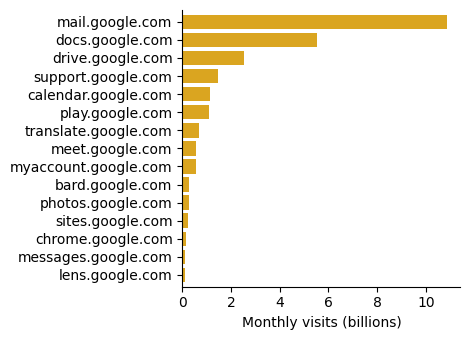

In [290]:
# Selection of subdomains unrelated to search:
gsubservices_df = subgoogle_visits_df.loc[~subgoogle_visits_df['domain'].isin(google_searches)].sort_values('monthly_visits', ascending=False)

# Plot monthly visits:
pl.figure(figsize=(5,3.5))
(gsubservices_df.set_index('domain')['monthly_visits'].iloc[-40::-1] / 1e9).plot(kind='barh', width=0.8, color='goldenrod')
pl.xlabel('Monthly visits (billions)')
pl.tight_layout()
pl.ylabel(None)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#pl.savefig('../resultados/10_artigo/images/visits-google-subdomains.eps')
pl.show()

In [ ]:
# Assigning an industry to google service:
gsubservices_ind_df = gsubservices_df.head(10).copy()
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'mail.google.com', 'industry'] = 'Email'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'docs.google.com', 'industry'] = 'Programming and Developer Software'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'drive.google.com', 'industry'] = 'File Sharing and Hosting'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'calendar.google.com', 'industry'] = 'Computers Electronics and Technology - Other'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'translate.google.com', 'industry'] = 'Dictionaries and Encyclopedias'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'meet.google.com', 'industry'] = 'Computers Electronics and Technology - Other'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'bard.google.com', 'industry'] = 'Computers Electronics and Technology - Other'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'photos.google.com', 'industry'] = 'File Sharing and Hosting'
gsubservices_ind_df.loc[gsubservices_ind_df['domain'] == 'sites.google.com', 'industry'] = 'Web Hosting and Domain Names'

# Join google services to Web dataset:
web_google_df = pd.concat([web_df, gsubservices_ind_df], ignore_index=True).sort_values('monthly_visits', ascending=False)
assert xd.iskeyQ(web_google_df.dropna(subset='domain')[['domain']]), 'More than one row per domain.'

In [208]:
def list_industry_domains(df, industry, head=5, view_cols=['domain', 'industry', 'position_industry', 'monthly_visits']):
    sel_df = df.loc[df['industry'] == industry].head(head)[view_cols]
    return sel_df

In [209]:
list_industry_domains(web_google_df, 'Email')

,domain,industry,position_industry,monthly_visits
1336963,mail.google.com,Email,NaN,1.088000e+10
14,live.com,Email,1.0,2.019000e+09
28,mail.ru,Email,2.0,1.170000e+09
472,list-manage.com,Email,3.0,1.270000e+08
276,web.de,Email,4.0,1.229000e+08


In [220]:
list_industry_domains(web_google_df, 'Programming and Developer Software', head=15)

,domain,industry,position_industry,monthly_visits
1336964,docs.google.com,Programming and Developer Software,NaN,5.539000e+09
21,office.com,Programming and Developer Software,1.0,1.541000e+09
32,microsoftonline.com,Programming and Developer Software,2.0,1.239000e+09
33,microsoft.com,Programming and Developer Software,3.0,9.778000e+08
107,yiyouliao.com,Programming and Developer Software,4.0,4.650000e+08
81,github.com,Programming and Developer Software,5.0,4.251000e+08
101,office365.com,Programming and Developer Software,6.0,3.014000e+08
303,stackoverflow.com,Programming and Developer Software,7.0,1.961000e+08
250,ilovepdf.com,Programming and Developer Software,8.0,1.485000e+08
307,atlassian.net,Programming and Developer Software,9.0,1.343000e+08


In [213]:
list_industry_domains(web_google_df, 'File Sharing and Hosting')

,domain,industry,position_industry,monthly_visits
1336965,drive.google.com,File Sharing and Hosting,NaN,2.534000e+09
225,mediafire.com,File Sharing and Hosting,1.0,1.863000e+08
197,dropbox.com,File Sharing and Hosting,2.0,1.492000e+08
266,mega.nz,File Sharing and Hosting,3.0,1.461000e+08
408,imgur.io,File Sharing and Hosting,4.0,1.254000e+08


In [215]:
list_industry_domains(web_google_df, 'Computers Electronics and Technology - Other', head=10)

,domain,industry,position_industry,monthly_visits
23,openai.com,Computers Electronics and Technology - Other,1.0,1.561000e+09
1336967,calendar.google.com,Computers Electronics and Technology - Other,NaN,1.118000e+09
47,zoom.us,Computers Electronics and Technology - Other,2.0,8.297000e+08
43,sharepoint.com,Computers Electronics and Technology - Other,3.0,7.036000e+08
68,t.me,Computers Electronics and Technology - Other,4.0,6.967000e+08
1336970,meet.google.com,Computers Electronics and Technology - Other,NaN,5.697000e+08
134,aol.com,Computers Electronics and Technology - Other,5.0,3.238000e+08
1336972,bard.google.com,Computers Electronics and Technology - Other,NaN,2.916000e+08
116,adobe.com,Computers Electronics and Technology - Other,6.0,2.831000e+08
157,wordpress.com,Computers Electronics and Technology - Other,7.0,2.726000e+08


In [217]:
list_industry_domains(web_google_df, 'Dictionaries and Encyclopedias')

,domain,industry,position_industry,monthly_visits
7,wikipedia.org,Dictionaries and Encyclopedias,1.0,4.413000e+09
59,quora.com,Dictionaries and Encyclopedias,2.0,7.293000e+08
1336969,translate.google.com,Dictionaries and Encyclopedias,NaN,6.937000e+08
96,deepl.com,Dictionaries and Encyclopedias,3.0,2.405000e+08
165,eksisozluk1923.com,Dictionaries and Encyclopedias,4.0,1.463000e+08


## Manual labeling

Let's export the top domains complete in terms of name so they can be annnotated manually:

In [24]:
# Select top websites with domain name informed:
top_w_name = top_rank_df['domain'].isnull().astype(int).cumsum() == 0
top_w_name_df = top_rank_df.loc[top_w_name]
xe.checkMissing(top_w_name_df)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [25]:
# Export table for manual annotation:
domains2label_df = top_w_name_df[['position', 'domain', 'industry']].copy()
domains2label_df['position'] = domains2label_df['position'].astype(int)
#domains2label_df.to_csv('../data/raw/domains-to-annotate_v01.csv', index=False)

## Analysing annotated websites

In the previous section we exported a list of top domains to be annotated. Now we load the annotated list and 
analyze it.

### Load data

In [26]:
# Load data:
annot_df = pd.read_csv('../data/cleaned/domains-annotated_v02.csv')

In [27]:
# Join with Similar Web data:
annot_to_join_df = annot_df.set_index('domain').drop(['position', 'industry'], axis=1)
top_w_annot_df = top_w_name_df.join(annot_to_join_df, on='domain', how='left')

In [28]:
xe.checkMissing(annot_df)

Colunas com valores faltantes:
                   coluna    N     %
3     software_as_service  2.0  1.72
4        content_producer  7.0  6.03
5   user_content_platform  3.0  2.59
6             needs_login  3.0  2.59
7            charge_users  6.0  5.17
8              mainly_web  3.0  2.59
9                   owner  6.0  5.17
10             for_profit  6.0  5.17
11          owner_country  6.0  5.17


In [29]:
# List of columns with binary annotations:
annot_binary_cols = ['user_content_platform', 'needs_login', 'content_producer', 'mainly_web', 'software_as_service', 'charge_users', 'for_profit']

# Labels for fraction bar plot below:
feat_labels = {'software_as_service': {0.0: 'Not SaaS', 1.0: 'SaaS*'},
               'content_producer': {0.0: 'No own content', 1.0: 'Content producer'},
               'user_content_platform': {0.0: 'No user content', 1.0: 'Platform for content*'},
               'needs_login': {0.0: 'No login required', 1.0: 'Requires login*'},
               'charge_users': {0.0: 'Free for main use', 1.0: 'Charges usage'},
               'mainly_web': {0.0: 'Has offline activities', 1.0: 'Online business'},
               'for_profit': {0.0: 'Non-profit', 1.0: 'For profit'}
              }

In [208]:
annot_df.query('software_as_service == 0').iloc[60:]

,position,domain,industry,software_as_service,content_producer,user_content_platform,needs_login,charge_users,mainly_web,owner,for_profit,owner_country
72,73,spotify.com,Music,0.0,1.0,1.0,1.0,0.0,1.0,Spotify,1.0,Sweden
75,76,uol.com.br,News and Media,0.0,1.0,0.0,0.0,0.0,1.0,Grupo Folha,1.0,Brazil
76,77,cricbuzz.com,Fantasy Sports,0.0,1.0,0.0,0.0,0.0,1.0,The Times Group,1.0,India
77,78,etsy.com,Marketplace,0.0,0.0,1.0,0.0,0.0,1.0,Etsy,1.0,United States
79,80,aliexpress.com,Marketplace,0.0,0.0,1.0,0.0,0.0,1.0,Alibaba Group,1.0,China
80,81,paypal.com,Banking Credit and Lending,0.0,0.0,0.0,1.0,1.0,1.0,Paypal,1.0,United States
81,82,amazon.de,Marketplace,0.0,1.0,1.0,0.0,0.0,0.0,Amazon,1.0,United States
82,83,chaturbate.com,Adult,0.0,0.0,1.0,0.0,0.0,1.0,Multi Media LLC,1.0,United States
83,84,github.com,Programming and Developer Software,0.0,0.0,1.0,1.0,0.0,1.0,Microsoft,1.0,United States
84,85,dailymail.co.uk,News and Media,0.0,1.0,0.0,0.0,0.0,1.0,Daily Mail and General Trust,1.0,United Kingdom


Here we verify the composition of the top websites in terms of number of websites with each property. Each website counts as 1, regardless of how many visits they have.

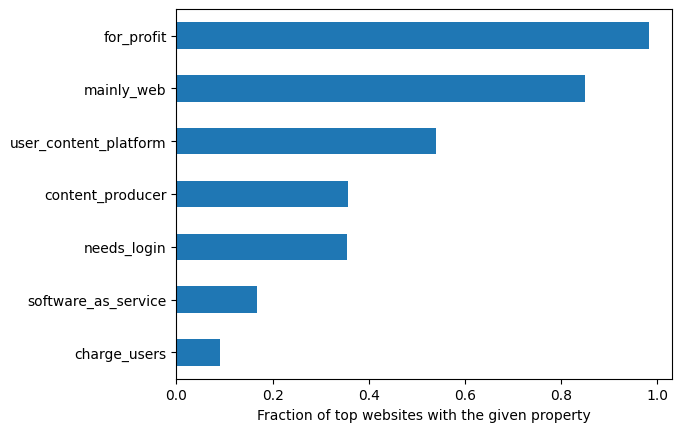

In [209]:
# Fraction of websites with each property:
annot_df[annot_binary_cols].mean().sort_values().plot(kind='barh')
pl.xlabel('Fraction of top websites with the given property')
pl.show()

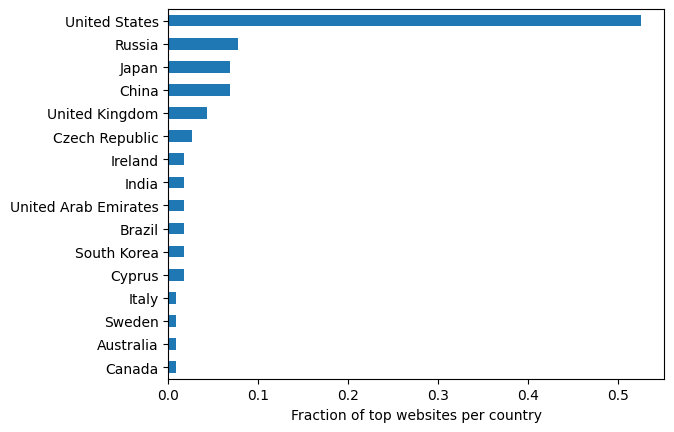

In [210]:
# Number of websites per country:
n_top_websites_per_country = annot_df['owner_country'].value_counts(ascending=True)
(n_top_websites_per_country / len(annot_df)).plot(kind='barh')
pl.xlabel('Fraction of top websites per country')
pl.show()

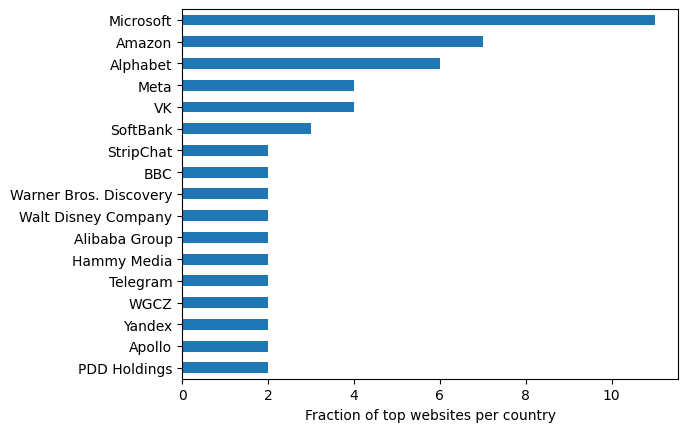

In [211]:
# Number of websites per owner:
n_top_websites_per_owner = annot_df['owner'].value_counts(ascending=True)
n_top_websites_per_owner.loc[n_top_websites_per_owner > 1].plot(kind='barh')
pl.xlabel('Fraction of top websites per country')
pl.show()

In [212]:
n_top_websites_per_owner.tail(10)

Walt Disney Company        2
Warner Bros. Discovery     2
BBC                        2
StripChat                  2
SoftBank                   3
VK                         4
Meta                       4
Alphabet                   6
Amazon                     7
Microsoft                 11
Name: owner, dtype: int64

In [213]:
annot_df.query('owner == "SoftBank"')

,position,domain,industry,software_as_service,content_producer,user_content_platform,needs_login,charge_users,mainly_web,owner,for_profit,owner_country
15,16,yahoo.co.jp,News and Media,0.0,1.0,0.0,0.0,0.0,1.0,SoftBank,1.0,Japan
52,53,news.yahoo.co.jp,News and Media,0.0,1.0,0.0,0.0,0.0,1.0,SoftBank,1.0,Japan
107,108,line.me,Social Networks and Online Communities,1.0,0.0,1.0,1.0,0.0,1.0,SoftBank,1.0,Japan


### Distribution of visits per property

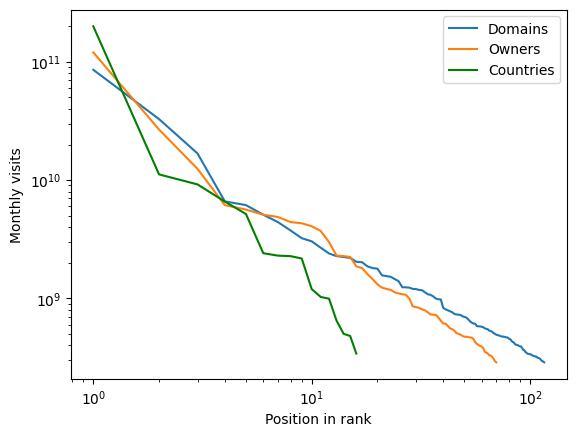

In [43]:
visits_per_domain  = top_w_annot_df.groupby('domain')['monthly_visits'].sum().sort_values(ascending=False)
visits_per_owner   = top_w_annot_df.groupby('owner')['monthly_visits'].sum().sort_values(ascending=False)
visits_per_country = top_w_annot_df.groupby('owner_country')['monthly_visits'].sum().sort_values(ascending=False)
n_domains   = len(visits_per_domain)
n_owners    = len(visits_per_owner)
n_countries = len(visits_per_country)
pos_visits_per_domain = np.arange(1, 1 + n_domains)
pos_visits_per_owner = np.arange(1, 1 + n_owners)
pos_visits_per_country = np.arange(1, 1 + n_countries)
pl.plot(pos_visits_per_domain, visits_per_domain.values, label='Domains')
pl.plot(pos_visits_per_owner, visits_per_owner.values, label='Owners')
pl.plot(pos_visits_per_country, visits_per_country.values, label='Countries', color='g')

pl.yscale('log')
pl.xscale('log')
pl.legend()
pl.ylabel('Monthly visits')
pl.xlabel('Position in rank')
pl.show()

In [44]:
print('Log-log slope for domains: {:.3f}'.format(get_beta(visits_per_domain)))
print('Log-log slope for owners: {:.3f}'.format(get_beta(visits_per_owner)))
print('Log-log slope for countries: {:.3f}'.format(get_beta(visits_per_country)))

Log-log slope for domains: -0.983
Log-log slope for owners: -1.219
Log-log slope for countries: -1.998


We see above that the monthly visits is more concentrated when computed in terms of owners, and even more when computed in terms of countries. 

Below we compare the slope of the lines with the slope one gets when randomly aggregating the monthly visits into a smaller set of instances.
It seems that doing so may actually decrease the slope, making the distribution less concentrated. It makes sense, since the visits are randomly 
mixed, making it more equal.

Thus, the increase in concentration we see when grouping by country and owner is not an artifact caused by grouping itself, but a result of the 
exact way this grouping happens in the real world.

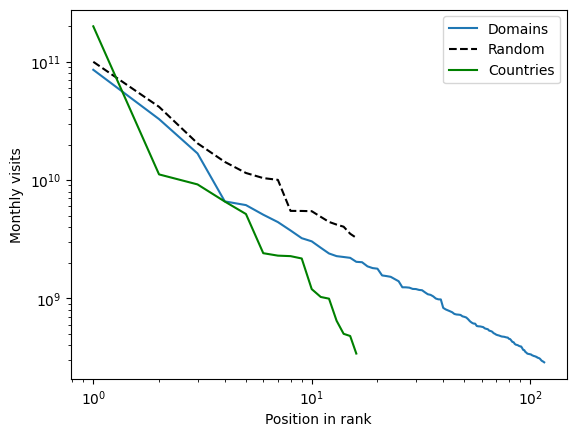

In [45]:
rnd_class = np.random.randint(0, len(visits_per_country), len(top_w_annot_df))

visits_per_rnd     = top_w_annot_df.groupby(rnd_class)['monthly_visits'].sum().sort_values(ascending=False)
n_rnd    = len(visits_per_rnd)
pos_visits_per_rnd = np.arange(1, 1 + n_rnd)
pl.plot(pos_visits_per_domain, visits_per_domain.values, label='Domains')
pl.plot(pos_visits_per_rnd, visits_per_rnd.values, label='Random', linestyle='--', color='k')
pl.plot(pos_visits_per_country, visits_per_country.values, label='Countries', color='g')

pl.yscale('log')
pl.xscale('log')
pl.legend()
pl.ylabel('Monthly visits')
pl.xlabel('Position in rank')
pl.show()

#### Aggregating visits per domain, owner and country

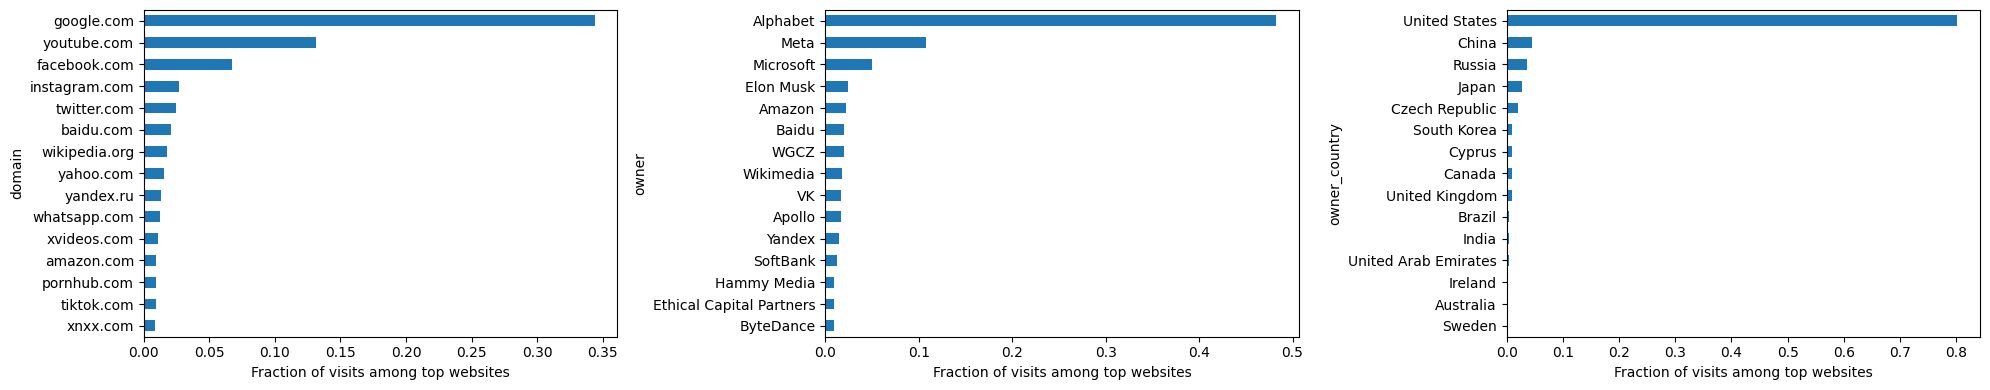

In [46]:
pl.figure(figsize=(20,4))

total_top_visits = top_w_annot_df['monthly_visits'].sum()
show_k_top = 15

pl.subplot(1,3,1)
(visits_per_domain / total_top_visits).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of visits among top websites')

pl.subplot(1,3,2)
(visits_per_owner / total_top_visits).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of visits among top websites')

pl.subplot(1,3,3)
(visits_per_country / total_top_visits).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of visits among top websites')

pl.tight_layout()
pl.show()

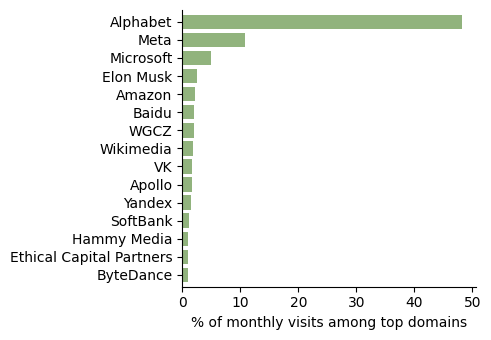

In [218]:
# Plot for the paper (top 116 traffic share per final owner):
pl.figure(figsize=(5,3.5))
(visits_per_owner / total_top_visits * 100).sort_values().iloc[-show_k_top:].plot(kind='barh', width=0.8, color=hsv_to_rgb((0.27, 0.3, 0.7)))
pl.xlabel('% of monthly visits among top domains')
pl.ylabel(None)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/top-owners-traffics.eps')
pl.show()

#### Fraction of websites with each property

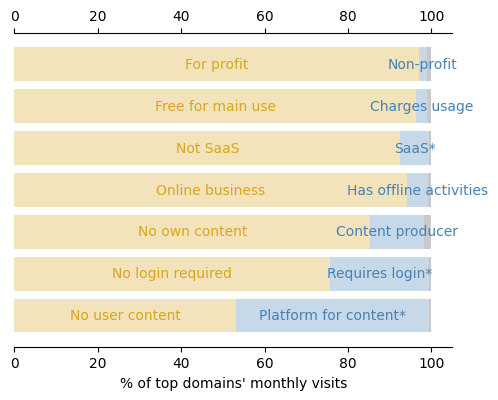

In [105]:
# Plot fraction of visits that happen under each website type:
pl.figure(figsize=(5.2,4))
top_site_dists = compute_bin_feat_dist(top_w_annot_df, annot_binary_cols)
for i, c in enumerate(annot_binary_cols):
    plot_square_pie(top_site_dists, feat_labels, c, i, factor=100)
ax = pl.gca()
for s in ['right', 'left']:
    ax.spines[s].set_visible(False)
pl.tick_params(labelleft=False, left=False, top=True, labeltop=True)
pl.tight_layout(pad=1.4)
pl.xlabel("% of top domains' monthly visits")
#pl.savefig('../resultados/10_artigo/images/top-traffic-share-per-property.png', dpi=600)
pl.show()

In [106]:
top_site_dists

{'user_content_platform': user_content_platform
 0.0    0.530554
 1.0    0.462629
 Name: monthly_visits, dtype: float64,
 'needs_login': needs_login
 0.0    0.756410
 1.0    0.236772
 Name: monthly_visits, dtype: float64,
 'content_producer': content_producer
 0.0    0.853790
 1.0    0.127764
 Name: monthly_visits, dtype: float64,
 'mainly_web': mainly_web
 1.0    0.941828
 0.0    0.050784
 Name: monthly_visits, dtype: float64,
 'software_as_service': software_as_service
 0.0    0.925052
 1.0    0.069596
 Name: monthly_visits, dtype: float64,
 'charge_users': charge_users
 0.0    0.963730
 1.0    0.024528
 Name: monthly_visits, dtype: float64,
 'for_profit': for_profit
 1.0    0.969747
 0.0    0.019020
 Name: monthly_visits, dtype: float64}

In [136]:
# Domains non-profit:
annot_df.query('for_profit == 0')

,position,domain,industry,software_as_service,content_producer,user_content_platform,needs_login,charge_users,mainly_web,owner,for_profit,owner_country
6,7,wikipedia.org,Dictionaries and Encyclopedias,0.0,0.0,1.0,0.0,0.0,1.0,Wikimedia,0.0,United States
102,103,archiveofourown.org,Books and Literature,0.0,0.0,1.0,0.0,0.0,1.0,Organization for Transformative Works,0.0,United States


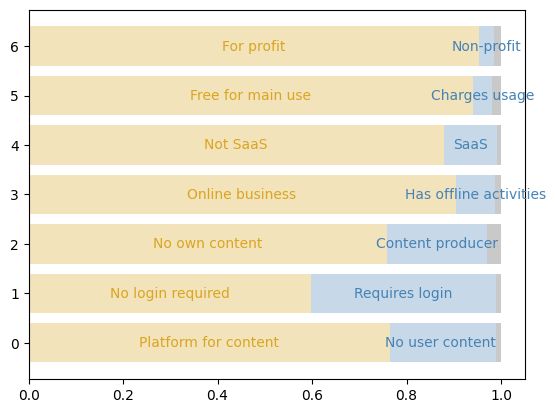

In [137]:
# Plot fraction of visits that happen under each website type (excluding Search Engines):
sel_annot_df = top_w_annot_df.query('industry !="Search Engines"')
top_sel_dists = compute_bin_feat_dist(sel_annot_df, annot_binary_cols)
for i, c in enumerate(annot_binary_cols):
    plot_square_pie(top_sel_dists, feat_labels, c, i)

In [138]:
top_sel_dists

{'user_content_platform': user_content_platform
 1.0    0.765646
 0.0    0.223071
 Name: monthly_visits, dtype: float64,
 'needs_login': needs_login
 0.0    0.596861
 1.0    0.391856
 Name: monthly_visits, dtype: float64,
 'content_producer': content_producer
 0.0    0.758024
 1.0    0.211448
 Name: monthly_visits, dtype: float64,
 'mainly_web': mainly_web
 1.0    0.903726
 0.0    0.084048
 Name: monthly_visits, dtype: float64,
 'software_as_service': software_as_service
 0.0    0.879118
 1.0    0.112024
 Name: monthly_visits, dtype: float64,
 'charge_users': charge_users
 0.0    0.939974
 1.0    0.040594
 Name: monthly_visits, dtype: float64,
 'for_profit': for_profit
 1.0    0.953089
 0.0    0.031478
 Name: monthly_visits, dtype: float64}

#### Clustering

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import xavy.clustering as cl

Let's create a function that compares the average property of all domains to the average property of the clusters: 

In [32]:
def show_avg_features(cluster_annot_df, annot_binary_cols, n_clusters, cmap='tab10'):
    """
    For each cluster, compare the fraction of websites with each 
    characteristic with the overall fraction.
    """
    c = pl.get_cmap(cmap)
    pl.figure(figsize=(1 + 3 * n_clusters, 4))
    for i in range(1, n_clusters + 1):
        pl.subplot(1, n_clusters, i)
        cluster_annot_df[annot_binary_cols].mean().plot(kind='barh', color='0.8', width=0.8)
        cluster_annot_df.query('cluster_{:} == {:}'.format(n_clusters, i - 1))[annot_binary_cols].mean().plot(kind='barh', color=c(i), width=0.4, alpha=0.3, label='{:}'.format(i - 1))
        if i > 1:
            pl.tick_params(labelleft=False)
        pl.legend()
    pl.subplots_adjust(wspace=0)
    pl.show()

Now lets add to our data the cluster classification for several number of cluster splits:

In [47]:
# Fill missing values with the most frequent characteristic:
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(annot_df[annot_binary_cols])

# Cluster the domains:
cluster_annot_df = top_w_annot_df.copy()
for n_clusters in range(2, 9):
    agglom = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='average')
    cluster_annot_df['cluster_{}'.format(n_clusters)] = agglom.fit_predict(X)

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


We can use the dendogram below to identify how many clusters would be interesting to use:

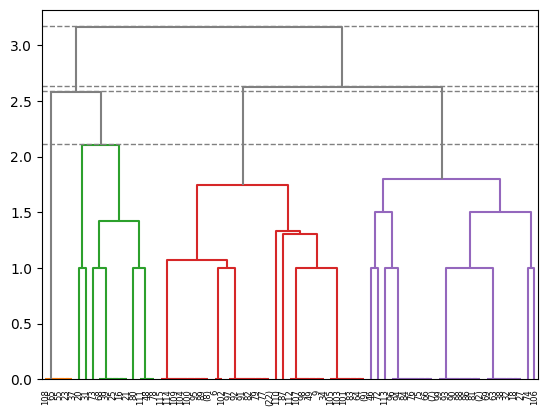

In [48]:
# Dendogram plot:
cl.plot_dendrogram(X, method='average', metric='manhattan', p=10)
l1 = 3.17; l2 = 2.63; l3 = 2.59; l4 = 2.11;  
pl.axhline(l1, color='gray', linewidth=1, linestyle='--')
pl.axhline(l2, color='gray', linewidth=1, linestyle='--')
pl.axhline(l3, color='gray', linewidth=1, linestyle='--')
pl.axhline(l4, color='gray', linewidth=1, linestyle='--')
pl.show()

The data and plot below shows the number of domains in each cluster and the average features of each cluster:

Number of domains per cluster


0    12
1    32
2    67
3     5
Name: cluster_4, dtype: int64

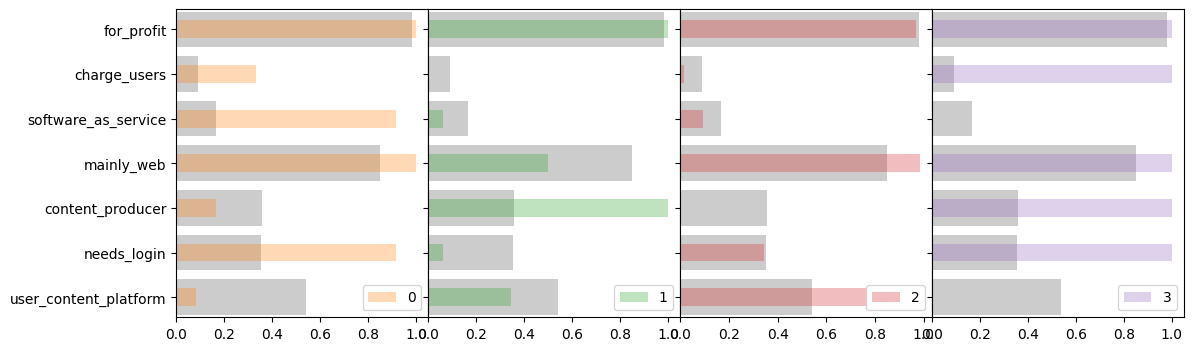

In [49]:
n_clusters = 4
print(xd.bold('Number of domains per cluster'))
display(cluster_annot_df['cluster_{:}'.format(n_clusters)].value_counts().sort_index())
show_avg_features(cluster_annot_df, annot_binary_cols, n_clusters)

With 4 clusters, the ones identified above are:

In [50]:
cluster_names = {0:'SaaS', 
                 1:'Open content providers', 
                 2:'Platforms', 
                 3:'Subscription content providers'}

In [51]:
cluster_annot_df.query('cluster_4 == 2').sort_values('monthly_visits', ascending=False).head(20)

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,...,owner,for_profit,owner_country,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,1,google.com,Computers Electronics and Technology,Search Engines,1.0,1.0,8.573000e+10,3.147000e+09,646.0,8.75,...,Alphabet,1.0,United States,0,2,2,2,0,6,6
1,2,youtube.com,Arts and Entertainment,TV Movies and Streaming,2.0,1.0,3.281000e+10,1.942000e+09,1204.0,11.56,...,Alphabet,1.0,United States,0,2,2,2,0,6,6
2,3,facebook.com,Computers Electronics and Technology,Social Networks and Online Communities,3.0,1.0,1.681000e+10,1.455000e+09,633.0,8.84,...,Meta,1.0,United States,0,2,2,2,0,5,2
3,4,instagram.com,Computers Electronics and Technology,Social Networks and Online Communities,4.0,2.0,6.602000e+09,1.102000e+09,494.0,11.15,...,Meta,1.0,United States,0,2,2,2,0,5,2
4,5,twitter.com,Computers Electronics and Technology,Social Networks and Online Communities,5.0,3.0,6.143000e+09,8.882000e+08,642.0,9.92,...,Elon Musk,1.0,United States,0,2,2,2,0,5,2
5,6,baidu.com,Computers Electronics and Technology,Search Engines,6.0,2.0,5.095000e+09,2.608000e+08,293.0,8.04,...,Baidu,1.0,China,0,2,2,2,0,6,6
7,8,wikipedia.org,Reference Materials,Dictionaries and Encyclopedias,7.0,1.0,4.413000e+09,9.646000e+08,234.0,3.11,...,Wikimedia,0.0,United States,0,2,2,2,0,6,6
6,7,yandex.ru,Computers Electronics and Technology,Search Engines,9.0,3.0,3.225000e+09,2.074000e+08,539.0,8.96,...,Yandex,1.0,Russia,0,2,2,2,0,6,6
20,21,whatsapp.com,Computers Electronics and Technology,Social Networks and Online Communities,10.0,4.0,3.033000e+09,4.715000e+08,1191.0,1.72,...,Meta,1.0,United States,0,2,2,2,0,5,2
8,9,xvideos.com,Adult,Adult,11.0,1.0,2.676000e+09,3.533000e+08,531.0,9.01,...,WGCZ,1.0,Czech Republic,0,2,2,2,0,6,6


In [104]:
cluster_annot_df[annot_binary_cols].mean()

user_content_platform    0.539823
needs_login              0.353982
content_producer         0.357798
mainly_web               0.849558
software_as_service      0.166667
charge_users             0.090909
for_profit               0.981818
dtype: float64

In [52]:
# Search engines were put into cluster 2:
cluster_annot_df.query('industry == "Search Engines"')[['domain', 'cluster_4']]

,domain,cluster_4
0,google.com,2
5,baidu.com,2
6,yandex.ru,2
27,bing.com,2
40,duckduckgo.com,2
38,google.com.br,2
74,ya.ru,2
117,ssyoutube.com,0
67,google.de,2
79,google.co.jp,2


In [53]:
# Examples of cluster 2 domains that are not search engines:
cluster_annot_df.query('cluster_4 == 2 and industry != "Search Engines"').sample(10)

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,...,owner,for_profit,owner_country,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
44,45,xhamster.desi,Adult,Adult,43.0,5.0,7.762000e+08,241400000.0,205.0,3.61,...,Hammy Media,1.0,Cyprus,0,2,2,2,0,6,6
51,52,ok.ru,Computers Electronics and Technology,Social Networks and Online Communities,63.0,11.0,5.512000e+08,55080000.0,650.0,11.31,...,VK,1.0,Russia,0,2,2,2,0,5,2
99,100,messenger.com,Computers Electronics and Technology,Social Networks and Online Communities,99.0,13.0,3.375000e+08,27050000.0,886.0,7.77,...,Meta,1.0,United States,0,2,2,2,0,5,2
30,31,discord.com,Computers Electronics and Technology,Social Networks and Online Communities,35.0,10.0,1.069000e+09,352200000.0,405.0,7.15,...,Discord,1.0,United States,0,2,2,2,0,5,2
50,51,msn.com,News and Media,News and Media,52.0,7.0,6.652000e+08,136300000.0,329.0,5.54,...,Microsoft,1.0,United States,0,2,2,2,0,6,6
120,121,news.google.com,News and Media,News and Media,90.0,16.0,3.922000e+08,52710000.0,335.0,3.77,...,Alphabet,1.0,United States,0,2,2,2,0,6,6
22,23,bilibili.com,Arts and Entertainment,Animation and Comics,29.0,1.0,1.200000e+09,91220000.0,1221.0,12.49,...,Bilibili,1.0,China,0,2,2,2,0,6,6
136,137,aniwave.to,Arts and Entertainment,Animation and Comics,101.0,2.0,3.345000e+08,18460000.0,731.0,5.18,...,NaN,NaN,NaN,0,2,2,2,0,6,6
49,50,booking.com,Travel and Tourism,Accommodation and Hotels,57.0,1.0,5.826000e+08,242300000.0,511.0,8.37,...,Booking Holdings,1.0,United States,0,2,2,2,0,6,6
4,5,twitter.com,Computers Electronics and Technology,Social Networks and Online Communities,5.0,3.0,6.143000e+09,888200000.0,642.0,9.92,...,Elon Musk,1.0,United States,0,2,2,2,0,5,2


In [54]:
cluster_share = (cluster_annot_df.query('industry != "Search Engines"').groupby('cluster_4')['monthly_visits'].sum() / total_top_visits)
cluster_share.index = cluster_share.index.map(cluster_names)
search_share = cluster_annot_df.query('industry == "Search Engines"')['monthly_visits'].sum() / total_top_visits
cluster_share = pd.concat([cluster_share, pd.Series([search_share], index=['Search engines'])]).sort_values()

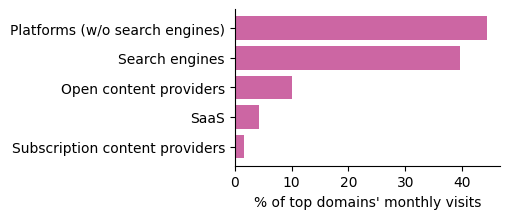

In [60]:
pl.figure(figsize=(5.2,2.3))
(cluster_share.rename({'Platforms': 'Platforms (w/o search engines)'}) * 100).plot(kind='barh', width=0.8, color=hsv_to_rgb((0.9, 0.5, 0.8)))
pl.xlabel("% of top domains' monthly visits")
pl.ylabel(None)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/10_artigo/images/top-clusters-traffic-share.eps')
pl.show()

### Export table

In [171]:
from xavy.utils import translate_dict

In [145]:
# Export all data for later use:
#cluster_annot_df.to_csv('../data/processed/top-116-domains-annotation-clustering.csv', index=False)

In [146]:
cluster_annot_df.columns

Index(['country_rank', 'domain', 'sector', 'industry', 'position',
       'position_industry', 'monthly_visits', 'unique_visitors',
       'visit_duration', 'pages_visit', 'bounce_rate', 'desktop_frac',
       'mobile_frac', 'traffic_share', 'traffic_share_industry',
       'total_monthly_time', 'software_as_service', 'content_producer',
       'user_content_platform', 'needs_login', 'charge_users', 'mainly_web',
       'owner', 'for_profit', 'owner_country', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'],
      dtype='object')

In [200]:
# Select relevant columns:
table_cols = ['domain', 'industry', 'monthly_visits', 'software_as_service', 'content_producer', 'user_content_platform', 
              'needs_login', 'charge_users', 'mainly_web', 'owner', 'for_profit', 'owner_country', 'cluster_4']
table_export_df = cluster_annot_df[table_cols].copy()
# Change visits scale:
table_export_df['monthly_visits'] = (table_export_df['monthly_visits'] / 1e9).round(3)
# Relabel clusters:
cluster_acron = {0:'SaaS', 
                 1:'OCP', 
                 2:'Plat', 
                 3:'SCP'}
table_export_df['cluster_4'] = table_export_df['cluster_4'].map(cluster_acron)
# Format binary columns as int (and fill NaNs):
for c in ['software_as_service', 'content_producer', 'user_content_platform', 'needs_login', 'charge_users', 'mainly_web', 'for_profit']:
    table_export_df[c] = table_export_df[c].fillna(-1).astype(int).astype(str).map(translate_dict({'-1':'-'}))
# Fill NaNs:
for c in ['owner', 'owner_country']:
    table_export_df[c] = table_export_df[c].fillna('-')

# Shorten long texts:
## Industry:
shortener = {'Social Networks and Online Communities': 'Social Networks', 
             'Computers Electronics and Technology - Other': r'Computers \& Tech - Other',
             'Programming and Developer Software': r'Prog. \& Dev. Software',
             'Video Games Consoles and Accessories': 'Video Games',
             'Graphics Multimedia and Web Design': r'Multimedia \& Web Design',
             'Ecommerce and Shopping - Other': 'Ecommerce - Other'}
table_export_df['industry'] = table_export_df['industry'].map(translate_dict(shortener))
table_export_df['industry'] = table_export_df['industry'].str.replace(' and ', r' \& ')
## Owner:
shortener = {'Organization for Transformative Works': 'Org. for Transf. Works',
             'Fenix International Limited': 'Fenix International Ltd',
             'Daily Mail and General Trust': r'Daily Mail \& General Trust'}
table_export_df['owner'] = table_export_df['owner'].map(translate_dict(shortener))
## Country:
shortener = {'United Arab Emirates': 'UAE', 'United States': 'USA', 'United Kingdom': 'UK', 'Czech Republic': 'Czech Rep.'}
table_export_df['owner_country'] = table_export_df['owner_country'].map(translate_dict(shortener))

# Change table column names:
labels = ['Domain', 'Industry', r'V ($10^9$)', 'SaaS', 'CP', 'Pl', 'Log', 'Ch', 'Web', 'Owner', r'\$', 'Country', 'Cl']
table_export_df.rename(dict(zip(table_cols, labels)), axis=1, inplace=True)

# Export:
table_size = 58
#table_export_df.iloc[:58].to_latex('../resultados/10_artigo/annot-domains-table_01.tex', index=False, longtable=False, escape=False)
#table_export_df.iloc[58:].to_latex('../resultados/10_artigo/annot-domains-table_02.tex', index=False, longtable=False, escape=False)

/tmp/ipykernel_19149/427898215.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_export_df.iloc[:58].to_latex('../resultados/10_artigo/annot-domains-table_01.tex', index=False, longtable=False, escape=False)
/tmp/ipykernel_19149/427898215.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_export_df.iloc[58:].to_latex('../resultados/10_artigo/annot-domains-table_02.tex', index=False, longtable=False, escape=False)


### Distribution of total time spent per property

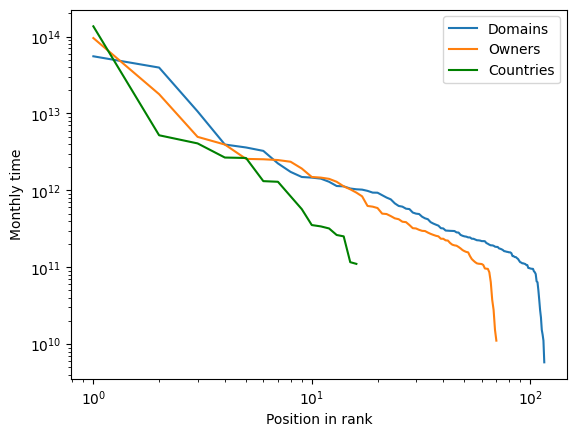

In [201]:
time_per_domain  = top_w_annot_df.groupby('domain')['total_monthly_time'].sum().sort_values(ascending=False)
time_per_owner   = top_w_annot_df.groupby('owner')['total_monthly_time'].sum().sort_values(ascending=False)
time_per_country = top_w_annot_df.groupby('owner_country')['total_monthly_time'].sum().sort_values(ascending=False)
n_domains_time   = len(time_per_domain)
n_owners_time    = len(time_per_owner)
n_countries_time = len(time_per_country)
pos_time_per_domain = np.arange(1, 1 + n_domains_time)
pos_time_per_owner = np.arange(1, 1 + n_owners_time)
pos_time_per_country = np.arange(1, 1 + n_countries_time)
pl.plot(pos_time_per_domain, time_per_domain.values, label='Domains')
pl.plot(pos_time_per_owner, time_per_owner.values, label='Owners')
pl.plot(pos_time_per_country, time_per_country.values, label='Countries', color='g')

pl.yscale('log')
pl.xscale('log')
pl.legend()
pl.ylabel('Monthly time')
pl.xlabel('Position in rank')
pl.show()

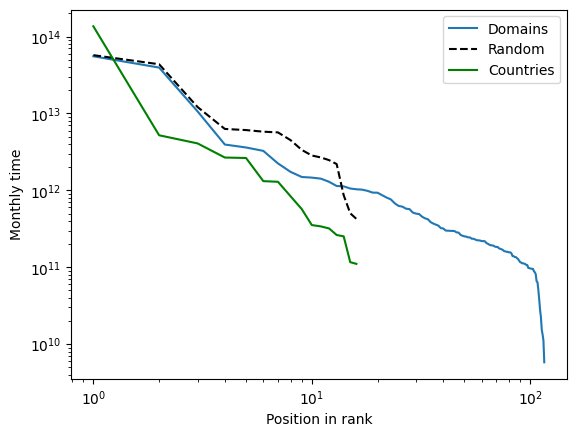

In [202]:
rnd_class = np.random.randint(0, len(time_per_country), len(top_w_annot_df))

time_per_rnd     = top_w_annot_df.groupby(rnd_class)['total_monthly_time'].sum().sort_values(ascending=False)
n_rnd_time    = len(time_per_rnd)
pos_time_per_rnd = np.arange(1, 1 + n_rnd_time)
pl.plot(pos_time_per_domain, time_per_domain.values, label='Domains')
pl.plot(pos_time_per_rnd, time_per_rnd.values, label='Random', linestyle='--', color='k')
pl.plot(pos_time_per_country, time_per_country.values, label='Countries', color='g')

pl.yscale('log')
pl.xscale('log')
pl.legend()
pl.ylabel('Monthly time')
pl.xlabel('Position in rank')
pl.show()

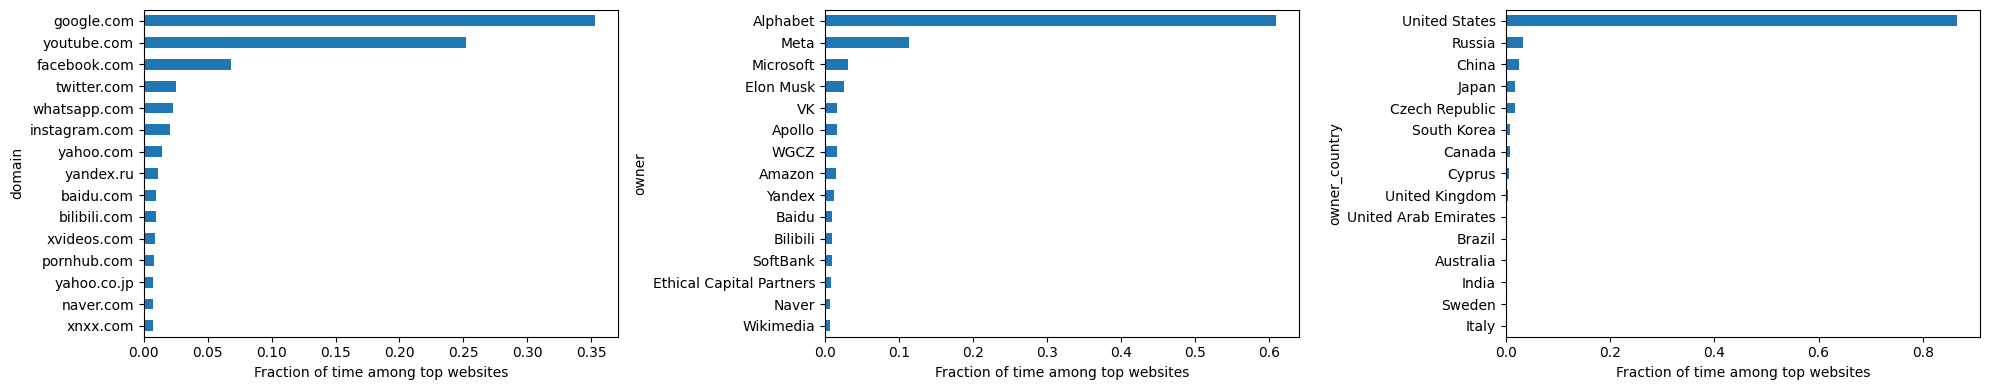

In [203]:
pl.figure(figsize=(20,4))

total_top_time = top_w_annot_df['total_monthly_time'].sum()
show_k_top = 15

pl.subplot(1,3,1)
(time_per_domain / total_top_time).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of time among top websites')

pl.subplot(1,3,2)
(time_per_owner / total_top_time).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of time among top websites')

pl.subplot(1,3,3)
(time_per_country / total_top_time).sort_values().iloc[-show_k_top:].plot(kind='barh')
pl.xlabel('Fraction of time among top websites')

pl.tight_layout()
pl.show()

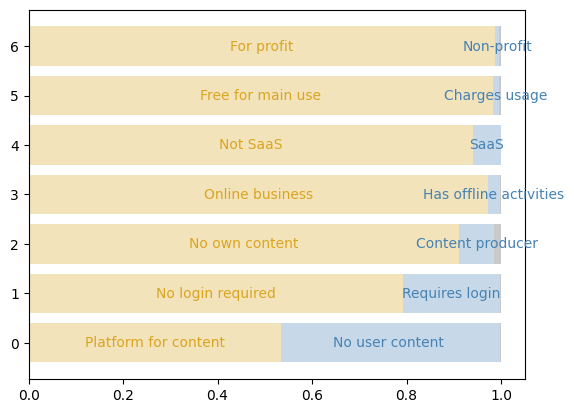

In [204]:
# Plot fraction of total time that happen under each website type:
top_site_dists = compute_bin_feat_dist(top_w_annot_df, annot_binary_cols, weights='total_monthly_time')
for i, c in enumerate(annot_binary_cols):
    plot_square_pie(top_site_dists, feat_labels, c, i)

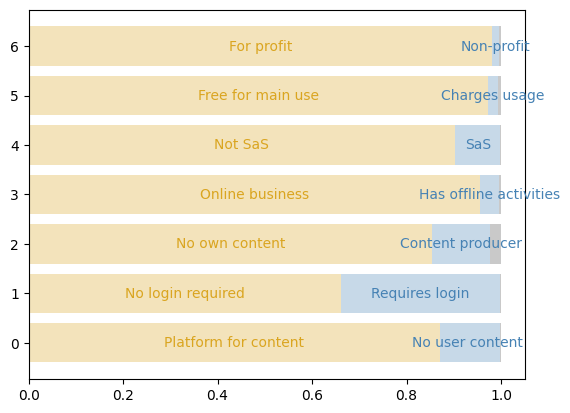

In [204]:
# Plot fraction of total time that happen under each website type (excluding Search Engines):
sel_annot_df = top_w_annot_df.query('industry !="Search Engines"')
top_sel_dists = compute_bin_feat_dist(sel_annot_df, annot_binary_cols, weights='total_monthly_time')
for i, c in enumerate(annot_binary_cols):
    plot_square_pie(top_sel_dists, feat_labels, c, i)

### Split annotations for AI labelling

In [113]:
from sklearn.metrics import accuracy_score

import xavy.mltools as ml

In [131]:
def parse_ai_annotations(ai_annot, feature, delimiter):
    """
    Parse a text containing one domain per line, followed by its annotation,
    into a DataFrame.

    Parameters
    ----------
    ai_annot : str
        Text output by AI with annotations about the domains.
    feature : str
        Name of the column containing AI annotations regarding the domains.
    delimiter : str
        The string that separates the domains from the annotations.

    Returns
    -------
    ai_annot_df : DataFrame
        Parsed annotations.
    """
    
    ai_annot_df = pd.DataFrame()
    # Split lines into entries:
    ai_annot_df['raw'] = list(filter(lambda s: len(s.strip()) > 0, ai_annot.split('\n')))
    
    # Extract domain from each entry:
    ai_annot_df['domain'] = ai_annot_df['raw'].str.split(delimiter).str.slice(0,1).str.join('').str.strip()
    # Extract annotation from each entry:
    ai_annot_df[feature]  = ai_annot_df['raw'].str.split(delimiter).str.slice(1,2).str.join('').str.strip().astype(int)
    
    # Sanity check: 
    assert len(ai_annot_df) == ai_annot_df['domain'].nunique()
    # Remove auxiliary column:
    ai_annot_df.drop('raw', axis=1, inplace=True)
    
    return ai_annot_df

In [46]:
# Split into two disjoint set using hash to avoid overlap if data is updated:
val_annot_df, test_annot_df = ml.train_test_split_by_string(annot_df, 0.5, 'domain')

In [54]:
feat_cols = list(feat_labels.keys())

#### Contagem de categorias

In [57]:
test_annot_df[feat_cols].sum()

software_as_service      10.0
content_producer         13.0
user_content_platform    29.0
needs_login              21.0
charge_users              5.0
mainly_web               42.0
for_profit               47.0
dtype: float64

In [56]:
val_annot_df[feat_cols].sum()

software_as_service       4.0
content_producer         26.0
user_content_platform    32.0
needs_login              19.0
charge_users              5.0
mainly_web               54.0
for_profit               61.0
dtype: float64

#### Ajuste fino com IA

In [114]:
feature = 'user_content_platform'

In [151]:
user_content_platform_prompt = """For each domain in the list that follows, answer with the number 1 if the website under the domain works as a platform for content produced by its users, and with 0 if not. Return the answers using the format: 
[domain]: [answer]
 
Social networks are the main example of this. In marketplaces and e-commerce, platforms that allow for third party sellers are considered user content platforms. News aggregators are not considered user content platforms as the contributors are mostly predefined by the website, and not voluntarely added. Comments made to a website, such as in some news websites, are not enough for them to be considered user content platforms. Search engines are not considered user content platforms."""

In [159]:
# Output for AI prompt:
for d in val_annot_df.dropna(subset=feature)['domain'].values:
    print(d)

google.com
twitter.com
baidu.com
tiktok.com
live.com
reddit.com
docomo.ne.jp
openai.com
office.com
netflix.com
dzen.ru
samsung.com
naver.com
pinterest.com
discord.com
twitch.tv
max.com
duckduckgo.com
xhamster.desi
roblox.com
stripchat.com
quora.com
fandom.com
globo.com
news.yahoo.co.jp
cnn.com
nytimes.com
booking.com
google.com.br
bbc.co.uk
spankbang.com
amazon.co.jp
accuweather.com
zhihu.com
espn.com
bbc.com
rakuten.co.jp
canva.com
imdb.com
ya.ru
spotify.com
uol.com.br
amazon.de
chaturbate.com
github.com
dailymail.co.uk
google.de
ozon.ru
walmart.com
avito.ru
amazon.co.uk
theguardian.com
tripmall.online
marca.com
amazon.in
aniwave.to
archiveofourown.org
pinduoduo.com
aol.com
temu.com
google.co.jp
onlyfans.com
foxnews.com
tsyndicate.com


In [160]:
ai_annot = """
google.com: 1
twitter.com: 1
baidu.com: 1
tiktok.com: 1
live.com: 0
reddit.com: 1
docomo.ne.jp: 0
openai.com: 1
office.com: 0
netflix.com: 1
dzen.ru: 0
samsung.com: 0
naver.com: 1
pinterest.com: 1
discord.com: 1
twitch.tv: 1
max.com: 0
duckduckgo.com: 0
xhamster.desi: 1
roblox.com: 1
stripchat.com: 1
quora.com: 1
fandom.com: 1
globo.com: 0
news.yahoo.co.jp: 1
cnn.com: 1
nytimes.com: 1
booking.com: 1
google.com.br: 1
bbc.co.uk: 1
spankbang.com: 1
amazon.co.jp: 1
accuweather.com: 1
zhihu.com: 1
espn.com: 1
bbc.com: 1
rakuten.co.jp: 1
canva.com: 1
imdb.com: 1
ya.ru: 0
spotify.com: 1
uol.com.br: 0
amazon.de: 1
chaturbate.com: 1
github.com: 1
dailymail.co.uk: 1
google.de: 1
ozon.ru: 0
walmart.com: 1
avito.ru: 0
amazon.co.uk: 1
theguardian.com: 1
tripmall.online: 0
marca.com: 1
amazon.in: 1
aniwave.to: 1
archiveofourown.org: 1
pinduoduo.com: 1
aol.com: 0
temu.com: 0
google.co.jp: 1
onlyfans.com: 1
foxnews.com: 1
tsyndicate.com: 0
    """

In [161]:
ai_annot_df = parse_ai_annotations(ai_annot, 'ai_' + feature, ':')

ai_annot_df = val_annot_df.dropna(subset=feature)[['domain', feature]].join(ai_annot_df.set_index('domain'), how='outer', on='domain')
ai_annot_df[feature] = ai_annot_df[feature].astype(int)
assert ai_annot_df.isnull().sum().sum() == 0

In [162]:
accuracy_score(ai_annot_df[feature], ai_annot_df['ai_' + feature])

0.625

In [158]:
ai_annot_df.loc[ai_annot_df[feature] != ai_annot_df['ai_' + feature]]

,domain,user_content_platform,ai_user_content_platform
24,dzen.ru,1,0
30,naver.com,1,0
56,booking.com,1,0
60,amazon.co.jp,1,0
67,rakuten.co.jp,1,0
70,imdb.com,1,0
72,spotify.com,1,0
81,amazon.de,1,0
83,github.com,1,0
86,ozon.ru,1,0


## Physical model

### Unique visitors

In [97]:
# Sites with the most unique visitors:
web_df.sort_values('unique_visitors', ascending=False).head()

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry
0,1,google.com,Computers Electronics and Technology,Search Engines,1.0,1.0,8.573000e+10,3.147000e+09,646.0,8.75,0.2830,0.412,0.588,0.186461,0.7930
1,2,youtube.com,Arts and Entertainment,TV Movies and Streaming,2.0,1.0,3.281000e+10,1.942000e+09,1204.0,11.56,0.2162,0.779,0.221,0.071361,0.6051
2,3,facebook.com,Computers Electronics and Technology,Social Networks and Online Communities,3.0,1.0,1.681000e+10,1.455000e+09,633.0,8.84,0.3130,0.417,0.583,0.036561,0.3323
3,4,instagram.com,Computers Electronics and Technology,Social Networks and Online Communities,4.0,2.0,6.602000e+09,1.102000e+09,494.0,11.15,0.3518,0.360,0.640,0.014359,0.1305
7,8,wikipedia.org,Reference Materials,Dictionaries and Encyclopedias,7.0,1.0,4.413000e+09,9.646000e+08,234.0,3.11,0.5960,0.406,0.594,0.009598,0.5642


### Number of visits per visitor, per month

In [23]:
n_visits_per_visitor = web_df['monthly_visits'] / web_df['unique_visitors']
assert n_visits_per_visitor.min() >= 1.0

In [80]:
high_n_visits = 20
visits_above = (n_visits_per_visitor > high_n_visits).sum()
total_domains = (n_visits_per_visitor > 0).sum()

assert total_domains <= (~web_df['monthly_visits'].isnull()).sum()
assert total_domains <= (~web_df['unique_visitors'].isnull()).sum()
assert total_domains == (~web_df['monthly_visits'].isnull() & ~web_df['unique_visitors'].isnull()).sum()

print('{:} of {:} ({:.3f}%) domains get more than {:} visits per visitor.'.format(visits_above, total_domains, visits_above / total_domains * 100, high_n_visits))

1163 of 893202 (0.130%) domains get more than 20 visits per visitor.


Text(0, 0.5, '# domains')

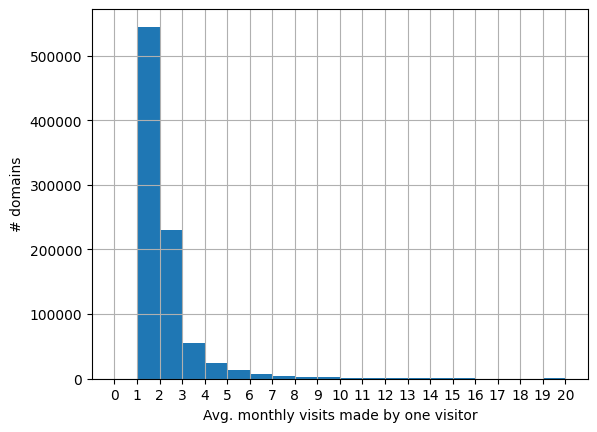

In [47]:
edges = np.arange(0,21,1)
n_visits_per_visitor.clip(upper=high_n_visits).hist(bins=edges)
pl.xticks(edges);
pl.xlabel('Avg. monthly visits made by one visitor')
pl.ylabel('# domains')

We see that most websites are visited only a few times per month. Some are visited a lot. These seems to be important (e.g. search engines) websites in niches (small communities).

In [232]:
# Domains with highest number of visits per visitor:
web_df.loc[n_visits_per_visitor.dropna().sort_values(ascending=False).index].head(20)

,country_rank,domain,sector,industry,position,position_industry,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,traffic_share,traffic_share_industry
24556,26330,9knx.com,Reference Materials,Maps,NaN,26.0,6659000.0,43045.0,1123.0,3.59,0.3938,1.000,0.000,NaN,0.005900
132,133,lazlogistics.ph,Business and Consumer Services,Shipping and Logistics,146.0,2.0,225700000.0,1914000.0,2553.0,23.22,0.1959,0.001,0.999,0.000491,0.077800
39405,43276,NaN,Gambling,Sports Betting,NaN,1287.0,608662.0,5205.0,4419.0,82.14,0.0827,1.000,0.000,NaN,0.000100
3258,3285,NaN,NaN,NaN,1358.0,NaN,37270000.0,324983.0,749.0,4.48,0.3027,0.001,0.999,0.000081,NaN
68097,77140,NaN,Computers Electronics and Technology,Search Engines,NaN,378.0,2121000.0,19660.0,624.0,3.60,0.2161,0.984,0.016,NaN,0.000020
104423,122261,NaN,Arts and Entertainment,Music,NaN,790.0,934141.0,8697.0,669.0,4.72,0.1749,1.000,0.000,NaN,0.000200
326,327,NaN,NaN,NaN,499.0,NaN,85830000.0,892807.0,2970.0,18.12,0.0320,0.001,0.999,0.000187,NaN
16785,17617,NaN,Gambling,Gambling - Other,NaN,189.0,1351000.0,14101.0,4624.0,77.16,0.0696,1.000,0.000,NaN,0.000900
237390,322648,NaN,Law and Government,Legal,NaN,291.0,773251.0,8599.0,564.0,2.99,0.2451,0.008,0.992,NaN,0.000500
28003,30235,NaN,Travel and Tourism,Accommodation and Hotels,NaN,169.0,1638000.0,18537.0,2644.0,30.44,0.0705,1.000,0.000,NaN,0.000600


In [26]:
# Number of visits per visitor, per month, for Google:
google = web_df.query('domain == "google.com"').iloc[0]
google['monthly_visits'] / google['unique_visitors']

27.241817604067364

### Time spent

According to [Statista](https://www.statista.com/statistics/617136/digital-population-worldwide/), there are 5.3 billion internet users in the World.

In [42]:
# Calculation of average time spent on the websites per month, per online person:
n_users     = 5.3e9
total_time  = (web_df['monthly_visits'] * web_df['visit_duration']).sum()
total_hours = total_time / 3600
avg_hours_per_month = total_hours / n_users
avg_hours_per_month

14.089304814414307

In [86]:
# Average monthly time spent per user (minutes):
avg_time_spent = (web_df['monthly_visits'] / web_df['unique_visitors'] * web_df['visit_duration'] / 60)

In [90]:
high_time_spent = 120
time_above = (avg_time_spent > high_time_spent).sum()
total_domains = (avg_time_spent >= 0).sum()

assert avg_time_spent.min() >= 0
assert total_domains == (~avg_time_spent.isnull()).sum()

print('{:} of {:} ({:.3f}%) domains get more than {:} monthly minutes per visitor.'.format(time_above, total_domains, time_above / total_domains * 100, high_time_spent))

7682 of 893202 (0.860%) domains get more than 120 monthly minutes per visitor.


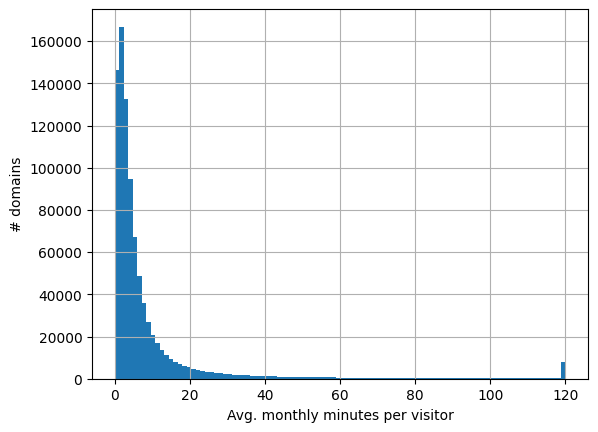

In [93]:
avg_time_spent.dropna().clip(upper=high_time_spent).hist(bins=100)
pl.xlabel('Avg. monthly minutes per visitor')
pl.ylabel('# domains');

# Trash

## Monthly visits

### Comparing industries

In [21]:
x = np.logspace(0, 4)
y = 3e8 * x ** -1
z = 3e8 * x ** -1 * np.exp(-0.001 * (x - 1) ** 0.8)

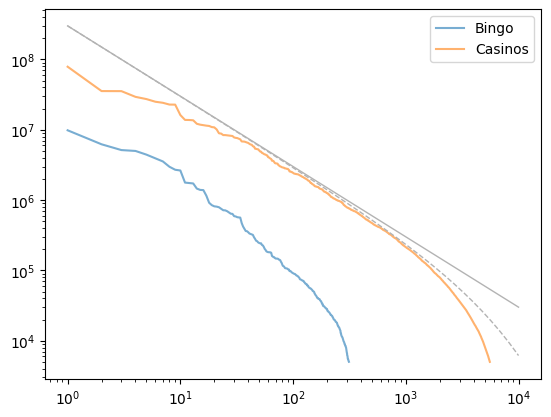

In [22]:
i = 57
sec, ind = scraped_industries_df.iloc[i]
sel_df = web_df.query(f'sector == "{sec}" and industry == "{ind}"')
pos = np.arange(1, 1 + len(sel_df))
pl.plot(pos, sel_df['monthly_visits'].sort_values(ascending=False).values, label=ind, alpha=0.6);

i = 58
sec, ind = scraped_industries_df.iloc[i]
sel_df = web_df.query(f'sector == "{sec}" and industry == "{ind}"')
pos = np.arange(1, 1 + len(sel_df))
pl.plot(pos, sel_df['monthly_visits'].sort_values(ascending=False).values, label=ind, alpha=0.6);

pl.plot(x, y, color='0.7', linestyle='-', linewidth=1)
pl.plot(x, z, color='0.7', linestyle='--', linewidth=1)

pl.xscale('log')
pl.yscale('log')
pl.legend();

### Powerlaw fit to the whole data

In [325]:
end_df = web_df.dropna(subset='monthly_visits').sort_values('monthly_visits', ascending=False)
end_powerlaw = PowerLaw(flat_x=True, huber=True)
end_pos = np.arange(1, 1 + len(end_df))
end_powerlaw.fit(end_pos, end_df['monthly_visits'])
end_model = end_powerlaw.predict(end_pos)

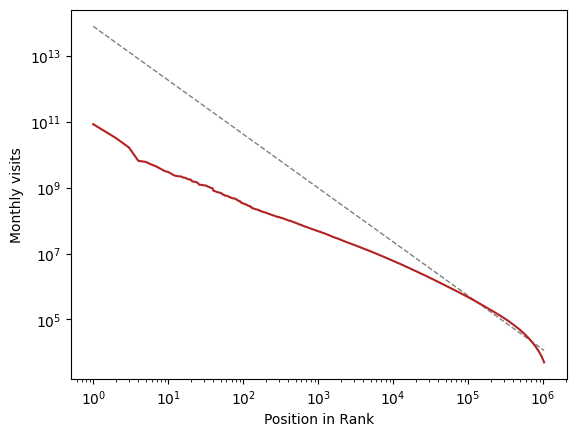

In [327]:
# Plot model 1-sigma-equivalent interval:
pl.plot(end_pos, end_model, label='Power law', color='k', alpha=0.5, linestyle='--', linewidth=1);
# Plot data:
pl.plot(end_pos, end_df['monthly_visits'], label='All industries', color='firebrick');
# Format:
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Position in Rank')
pl.ylabel('Monthly visits')
pl.show()

### Statistical variation on powerlaw parameters

The plot below shows that the statistical variation on the exponent of the powerlaw is very small.

In [223]:
def fit_powerlaw(X, y, model):

    dump  = model.fit(X, y)
    V0    = np.exp(model.intercept_) # Scale
    beta  = model.coef_[0]           # Exponent
    
    return V0, beta

In [296]:
# Fit 
pos_lim  = 200000 
n_trials = 4000
powerlaw_sample = np.array([fit_powerlaw(Xpos[:pos_lim], regen_rank(yvisits, pc_change, n_complete)[:pos_lim], lin_model) for _ in range(n_trials)])

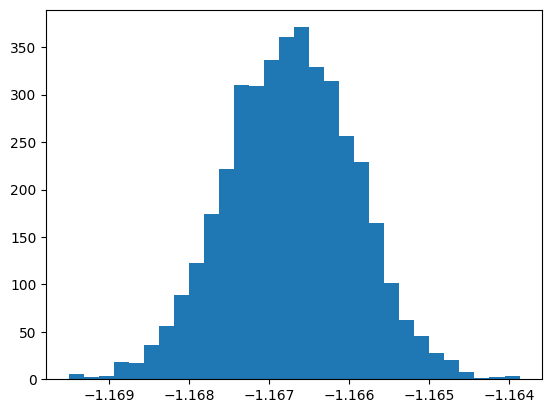

In [294]:
pl.hist(powerlaw_sample[:, 1], 30);

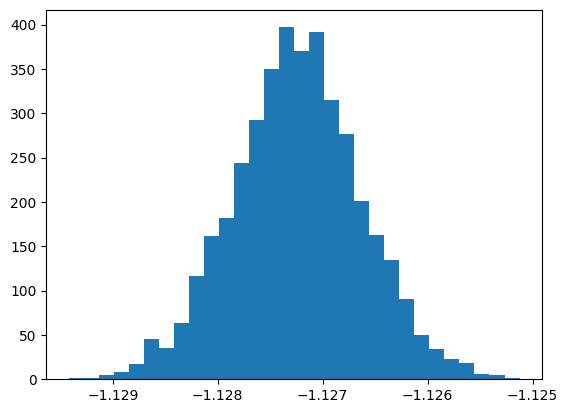

In [229]:
pl.hist(powerlaw_sample[:, 1], 30);

### Extrapolating the power-law model given an exponent

In [356]:
x = np.logspace(0,7, 100)
y_min = V0_min * x ** beta_min
y_max = V0_max * x ** beta_max

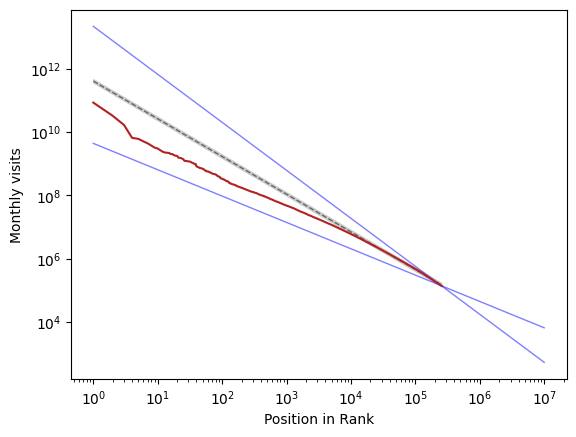

In [357]:
# Plot model 1-sigma-equivalent interval:
pc_dev = 1 + np.percentile(pc_change - pc_change.median(), [16, 84])
pl.fill_between(pos, visits_model * pc_dev[0], visits_model * pc_dev[1], color='0.8')
pl.plot(pos, visits_model, label='Power law', color='k', alpha=0.5, linestyle='--', linewidth=1);
pl.plot(x, y_min, label='Power law', color='b', alpha=0.5, linestyle='-', linewidth=1);
pl.plot(x, y_max, label='Power law', color='b', alpha=0.5, linestyle='-', linewidth=1);
# Plot data:
pl.plot(pos, visits, label='All industries', color='firebrick');
# Format:
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Position in Rank')
pl.ylabel('Monthly visits')
pl.show()

## Correlation between annotated features

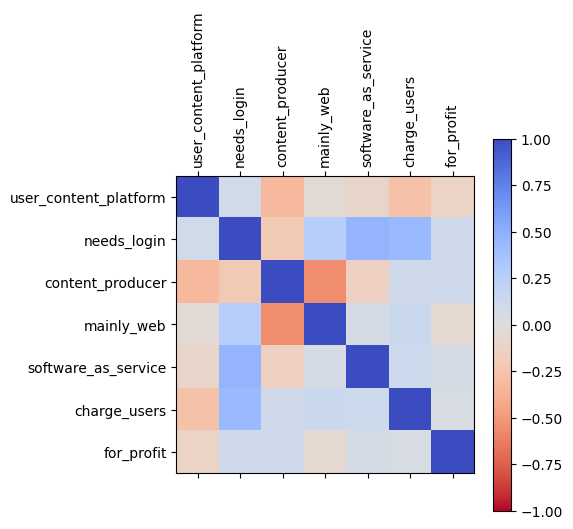

In [294]:
annot_corr_df = annot_df[annot_binary_cols].corr()

pl.matshow(annot_corr_df, cmap='coolwarm_r', vmin=-1, vmax=1)
pl.yticks(range(len(annot_binary_cols)), annot_binary_cols)
pl.xticks(range(len(annot_binary_cols)), annot_binary_cols, rotation=90)
pl.colorbar()
pl.show()